# Imports

In [1]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
import talos
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, LSTM, Lambda
from tensorflow.keras import regularizers
import tensorflow as tf

# Load data
load hospitalisations and trends for Belgium and France

In [3]:
# topics considered
list_topics = {
    #'Fièvre': '/m/0cjf0',
    #'Mal de gorge': '/m/0b76bty',
    #'Dyspnée': '/m/01cdt5',
    #'Agueusie': '/m/05sfr2',
    #'Anosmie': '/m/0m7pl',
    #'Coronavirus': '/m/01cpyy',
    #'Virus': '/m/0g9pc',
    #'Température corporelle humaine': '/g/1213j0cz',
    #'Épidémie': '/m/0hn9s',
    #'Symptôme': '/m/01b_06',
    #'Thermomètre': '/m/07mf1',
    #'Grippe espagnole': '/m/01c751',
    #'Paracétamol': '/m/0lbt3',
    #'Respiration': '/m/02gy9_',
    #'Toux': '/m/01b_21'
}

# hospitalisations features given as input
list_hosp_features = [
    #'NEW_HOSP',
    'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
]

geocodes = {
    'BE': "Belgique",
    'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-C': "Auvergne-Rhône-Alpes",
    'FR-J': 'Ile-de-France'
}

Additional information: what is the target, should some features remain unscaled?

In [4]:
# target, should be one of the hosp features
target = 'TOT_HOSP'

# features that should not be scaled
unscaled = [
    #'NEW_HOSP',
    #'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
    #'Fièvre',
    #'Mal de gorge',
    #'Dyspnée',
    #'Agueusie',
    #'Anosmie',
    #'Coronavirus',
    #'Virus',
    #'Température corporelle humaine',
    #'Épidémie',
    #'Symptôme',
    #'Thermomètre',
    #'Grippe espagnole',
    #'Paracétamol',
    #'Respiration',
    #'Toux',
]

In [5]:
date_begin = "2020-02-01"

def log_values(df, columns: list = None, base: int = 10, inf_value='drop'):
    """
    add log values to the dataframe
    :param df: dataframe to change
    :param columns: list of name of the columns that needs to be modified. None= all columns
    :param base: base for the logarithm. Supported: [10]. If not in the list, use logarithm in base e
    :param inf_value: value to give for the inf created by the log. Can be integer or 'drop' (dropping the values)
    :return dataframe with log values for the corresponding columns
    """
    if columns==None:
        columns = df.columns
    new_columns = [f"{name}_log" for name in columns]
        
    if base==10:
        df[new_columns] = np.log10(df[columns])
    else:
        df[new_columns] = np.log(df[columns]) / np.log(base)
        
    if inf_value == 'drop':
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
    else: #inf_value should be an integer
        df = df.replace([np.inf, -np.inf], inf_value)
    return df
        

def pct_values(df, columns: list = None, add_one: bool = False):
    """
    add percentage values to the dataframe
    :param df: dataframe to change
    :param columns: list of name of the columns that needs to be modified. None= all columns
    :param add_one: if True, the percentage of difference add a value of 100% to each percentage
    :return dataframe with pct change values for the corresponding columns
    """
    if columns==None:
        columns = df.columns
    new_columns = [f"{name}_pct" for name in columns]
    df[new_columns] = df[columns].pct_change()
    if add_one:
        df[new_columns] = df[new_columns] + 1
    return df
    

def create_dataframe_hospi(hospi_france_tot, hospi_france_new, hospi_belgium, department_france, geo, 
                           new_hosp_in=True, tot_hosp=True):
    """
    Creates the dataframe containing the number of daily new hospitalizations
    with respect to the date and the localisation (FR and BE)
    :param hospi_france_tot: url/path for the total french hospitalisations csv
    :param hospi_france_new: url/path for the new french hospitalisations csv
    :param hospi_belgium: url/path for the belgian hospitalisations csv
    :param department_france: url/path for the mapping of french department to regions
    :param geo: geocode of the region that should be incuded in the final dict
    :param new_hosp_in: if True, includes the new daily hospitalisations (inwards)
    :param tot_hosp: if True, includes the total hospitalisations
    :return dict of {geocode: hosp_df} where hosp is hospitalisation dataframe of each geocode
    """
    columns_be = {}  # only for belgium, not for france (the files are handled differently)
    data_columns = []  # final data columns that will be present in the df
    if new_hosp_in:
        columns_be['NEW_IN'] = 'sum'
        data_columns.append("NEW_HOSP")
    if tot_hosp:
        columns_be['TOTAL_IN'] = 'sum'
        data_columns.append("TOT_HOSP")
    if len(columns_be) == 0:
        raise Exception("no hospitalisation column specified")
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    departements = pd.read_csv(department_france)
    
    # French data: total hospitalisation
    if tot_hosp:
        hospitalisations = pd.read_csv(hospi_france_tot, sep=";", parse_dates=['jour'], date_parser=date_parser)
        hospitalisations = hospitalisations[hospitalisations['sexe'] == 0]  # sex=0: men and women
        data_fr_tot = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(
            ["regionTrends", "jour"], as_index=False).agg({"hosp": "sum"})
    
    # French data: new hospitalisation
    if new_hosp_in:
        hospitalisations = pd.read_csv(hospi_france_new, sep=";", parse_dates=['jour'], date_parser=date_parser)
        data_fr_new = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(
            ["regionTrends", "jour"],as_index=False).agg({"incid_hosp": "sum"})
    
    # merge the french data
    common_columns = ["regionTrends", "jour"]
    if tot_hosp and new_hosp_in:
        data_fr = data_fr_tot.merge(data_fr_new, how='outer',left_on=common_columns, right_on=common_columns).fillna(0)
    elif tot_hosp:
        data_fr = data_fr_tot
    elif new_hosp_in:
        data_fr = data_fr_new
    data_fr = data_fr.rename(columns={"jour": "DATE", "regionTrends": "LOC", "hosp": "TOT_HOSP", "incid_hosp": "NEW_HOSP"})
    
    # Belgian data
    data_be = pd.read_csv(hospi_belgium, parse_dates=['DATE'], date_parser=date_parser).groupby(
        ["DATE"], as_index=False).agg(columns_be).rename(
        columns={"TOTAL_IN": "TOT_HOSP", "NEW_IN": "NEW_HOSP"})
    data_be["LOC"] = "BE"
    
    # Full data
    full_data = data_fr.append(data_be).set_index(["LOC", "DATE"])
    
    # find smallest date for each loc and highest common date
    smallest = {}
    highest = {}
    for loc, date_current in full_data.index:
        if loc not in smallest or smallest[loc] > date_current:
            smallest[loc] = date_current
        if loc not in highest or highest[loc] < date_current:
            highest[loc] = date_current
        
    highest_date = min(highest.values())
    base_date = datetime.strptime(date_begin, "%Y-%m-%d").date()

    # Add "fake" data (zeroes before the beginning of the crisis) for each loc
    toadd = []
    add_entry = [0 for i in range(len(data_columns))]  # each missing entry consist of zero for each data col
    for loc, sm in smallest.items():
        end = sm.date()
        cur = base_date

        while cur != end:
            toadd.append([cur, loc, *add_entry])
            cur += timedelta(days=1)
            
    full_data = pd.DataFrame(toadd, columns=["DATE", "LOC", *data_columns]).append(full_data.reset_index()).set_index(
        ["LOC", "DATE"])
    data_dic = {}
    
    for k, v in geo.items():
        data_dic[k] = full_data.iloc[(full_data.index.get_level_values('LOC') == k) & 
                                     (full_data.index.get_level_values('DATE') <= highest_date)]
    return data_dic


def create_df_trends(url_trends, geo):
    """
    return dic of {geo: df} for the trends
    """
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    renaming = {v: k for k, v in list_topics.items()}  # change topic_mid to topic_title in the dataframe
    if len(renaming)==0:
        return {k: pd.DataFrame() for k in geocodes}
    result = {}
    for k, v in geo.items():
        all_trends = []
        for term in list_topics.keys():
            path = f"{url_trends}{k}-{term}.csv"
            encoded_path = requests.get(path).content
            df_trends = pd.read_csv(io.StringIO(encoded_path.decode("utf-8")),
                                    parse_dates=['date'], date_parser=date_parser
                                   ).rename(columns={"date": "DATE"})
            df_trends['LOC'] = k
            df_trends.rename(columns=renaming, inplace=True)
            df_trends.set_index(['LOC', 'DATE'], inplace=True)
            all_trends.append(df_trends)
        result[k] = pd.concat(all_trends, axis=1)
    return result

In [6]:
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi_belgium = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
url_department_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/france_departements.csv"
url_hospi_france_new = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi.csv"
url_hospi_france_tot = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi-total.csv"

# Percentage is True if we want to take the difference of variation between today and yesterday in percentage
# Total is True if we want to add the absolute total value to the input of the model
df_trends = create_df_trends(url_trends, geocodes)
df_hospi = create_dataframe_hospi(url_hospi_france_tot, url_hospi_france_new, url_hospi_belgium, 
                                  url_department_france, geocodes)
for k in geocodes.keys():
    # Rolling average of 7 days 
    df_hospi[k] = df_hospi[k].rolling(7, center=True).mean().dropna()
    df_trends[k] = df_trends[k].rolling(7, center=True).mean().dropna()
    df_hospi[k] = log_values(df_hospi[k], columns=['TOT_HOSP'])
    df_hospi[k] = pct_values(df_hospi[k], columns=['TOT_HOSP'])
    df_hospi[k] = df_hospi[k][list_hosp_features]
    
    """
    print(f"--------------------{k}-----------------------")
    plt.figure()
    plt.plot(df_hospi[k]['HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Diff hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_hospi[k]['TOT_HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Total hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_trends[k]['Fièvre'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Fièvre')
    plt.plot(df_trends[k]['Mal de gorge'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Mal de gorge')
    plt.plot(df_trends[k]['Agueusie'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Agueusie')
    plt.legend()
    plt.show()
    """

# Preprocess data

## Normalization [0,1]

In [7]:
df_hospi['BE']

TOT_HOSP
LOC DATE                   
BE  2020-03-12    38.000000
    2020-03-13    90.857143
    2020-03-14   161.857143
    2020-03-15   254.714286
    2020-03-16   375.285714
...                     ...
    2021-01-12  1940.428571
    2021-01-13  1924.857143
    2021-01-14  1915.857143
    2021-01-15  1909.285714
    2021-01-16  1909.285714

[311 rows x 1 columns]

In [8]:
inverse_param = {}
scaler = MinMaxScaler(feature_range=(0, 1))
for k in geocodes.keys():
    if len(list_topics) !=0:
        to_scale = [name for name in df_trends[k].columns if name not in unscaled]
        df_trends[k] = pd.DataFrame(scaler.fit_transform(df_trends[k].values), columns=to_scale, index=df_trends[k].index)
    # store a tuple of min,max
    inverse_param[k] = (df_hospi[k][target].min(), df_hospi[k][target].max())
    to_scale = [name for name in df_hospi[k].columns if name not in unscaled]
    df_hospi[k][to_scale] = pd.DataFrame(scaler.fit_transform(df_hospi[k][to_scale].values), columns=to_scale, index=df_hospi[k].index)
# store the inverse transform for the target only
inverse_transform = lambda df,k: df[[target]] * (inverse_param[k][1] - inverse_param[k][0]) + inverse_param[k][0] 
df_hospi['BE']

TOT_HOSP
LOC DATE                
BE  2020-03-12  0.000000
    2020-03-13  0.007370
    2020-03-14  0.017270
    2020-03-15  0.030217
    2020-03-16  0.047029
...                  ...
    2021-01-12  0.265263
    2021-01-13  0.263092
    2021-01-14  0.261837
    2021-01-15  0.260921
    2021-01-16  0.260921

[311 rows x 1 columns]

In [9]:
inverse_transform(df_hospi['BE'], 'BE')

TOT_HOSP
LOC DATE                   
BE  2020-03-12    38.000000
    2020-03-13    90.857143
    2020-03-14   161.857143
    2020-03-15   254.714286
    2020-03-16   375.285714
...                     ...
    2021-01-12  1940.428571
    2021-01-13  1924.857143
    2021-01-14  1915.857143
    2021-01-15  1909.285714
    2021-01-16  1909.285714

[311 rows x 1 columns]

## Days used for the forecast
Each forecast is done for `n_forecast` days and uses `n_samples` days before to construct the prediction

In [10]:
n_forecast = 1  # Number of days we want to predict
n_samples = 14  # Number of days used to make the prediction
shift_hospi = 1  # delay between a date and its newest hosp value for this date 
# (ex: 26/10's newest value is for 25/10)
shift_trends = 1  # delay between a date and its newest trends value for this date

## Add lag

In [11]:
def timeseries_shift(data, lag, dropna=True):
    """
    Changes all columns with their shifted data
    """
    return data.shift(lag).dropna()

for k in geocodes.keys():
    df_hospi[k] = timeseries_shift(df_hospi[k], shift_hospi)
    df_trends[k] = timeseries_shift(df_trends[k], shift_trends)

In [12]:
def timeseries_add_lag(data, lag, dropna=True):
    #Adds lagged values to dataframe
    df = pd.DataFrame(data)
    init_columns = df.columns
    columns = [df.shift(i) for i in range(lag-1, 0, -1)]
    renaming = {}  # rename the columns
    delay = lag-1
    for i in range(lag-1):
        for k in init_columns:
            renaming[k] = f'{k}(t-{delay})'
        columns[i].rename(columns=renaming ,inplace=True)
        delay -= 1
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df.dropna() if dropna else df


if len(list_topics) !=0:
    merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True).dropna() for k,v in geocodes.items()}
else:
    merged_df = {k: df_hospi[k] for k in geocodes}
    
# use the same date interval in all dataframes
min_date = datetime.strptime("1990-12-01", "%Y-%m-%d").date()
max_date = datetime.strptime("2050-12-01", "%Y-%m-%d").date()
for k in merged_df:
    index_date = merged_df[k].index.get_level_values(1)
    min_date = max(min_date, index_date.min())
    max_date = min(max_date, index_date.max())
for k in merged_df:
    merged_df[k] = merged_df[k].loc[pd.IndexSlice[:,min_date:max_date,:]]    

n_features = len(merged_df['BE'].columns)
lagged_df = {}
for k in geocodes.keys():
    lagged_df[k] = timeseries_add_lag(merged_df[k], n_samples)

In [13]:
merged_df['BE']

TOT_HOSP
LOC DATE                
BE  2020-03-16  0.030217
    2020-03-17  0.047029
    2020-03-18  0.068960
    2020-03-19  0.096528
    2020-03-20  0.124016
...                  ...
    2021-01-12  0.267653
    2021-01-13  0.265263
    2021-01-14  0.263092
    2021-01-15  0.261837
    2021-01-16  0.260921

[307 rows x 1 columns]

In [14]:
lagged_df['BE']

TOT_HOSP(t-13)  TOT_HOSP(t-12)  TOT_HOSP(t-11)  \
LOC DATE                                                         
BE  2020-03-29        0.030217        0.047029        0.068960   
    2020-03-30        0.047029        0.068960        0.096528   
    2020-03-31        0.068960        0.096528        0.124016   
    2020-04-01        0.096528        0.124016        0.154154   
    2020-04-02        0.124016        0.154154        0.186881   
...                        ...             ...             ...   
    2021-01-12        0.315459        0.312192        0.308727   
    2021-01-13        0.312192        0.308727        0.304464   
    2021-01-14        0.308727        0.304464        0.298747   
    2021-01-15        0.304464        0.298747        0.293628   
    2021-01-16        0.298747        0.293628        0.290262   

                TOT_HOSP(t-10)  TOT_HOSP(t-9)  TOT_HOSP(t-8)  TOT_HOSP(t-7)  \
LOC DATE                                                                      
BE  2020-03-29        0.096528       0.124016       0.154154       0.186881   
    2020-03-30        0.124016       0.154154       0.186881       0.228134   
    2020-03-31        0.154154       0.186881       0.228134       0.272613   
    2020-04-01        0.186881       0.228134       0.272613       0.323387   
    2020-04-02        0.228134       0.272613       0.323387       0.377268   
...                        ...            ...            ...            ...   
    2021-01-12        0.304464       0.298747       0.293628       0.290262   
    2021-01-13        0.298747       0.293628       0.290262       0.288568   
    2021-01-14        0.293628       0.290262       0.288568       0.284684   
    2021-01-15        0.290262       0.288568       0.284684       0.280103   
    2021-01-16        0.288568       0.284684       0.280103       0.275999   

                TOT_HOSP(t-6)  TOT_HOSP(t-5)  TOT_HOSP(t-4)  TOT_HOSP(t-3)  \
LOC DATE                                                                     
BE  2020-03-29       0.228134       0.272613       0.323387       0.377268   
    2020-03-30       0.272613       0.323387       0.377268       0.433719   
    2020-03-31       0.323387       0.377268       0.433719       0.493755   
    2020-04-01       0.377268       0.433719       0.493755       0.550505   
    2020-04-02       0.433719       0.493755       0.550505       0.600283   
...                       ...            ...            ...            ...   
    2021-01-12       0.288568       0.284684       0.280103       0.275999   
    2021-01-13       0.284684       0.280103       0.275999       0.272613   
    2021-01-14       0.280103       0.275999       0.272613       0.269844   
    2021-01-15       0.275999       0.272613       0.269844       0.267653   
    2021-01-16       0.272613       0.269844       0.267653       0.265263   

                TOT_HOSP(t-2)  TOT_HOSP(t-1)  TOT_HOSP  
LOC DATE                                                
BE  2020-03-29       0.433719       0.493755  0.550505  
    2020-03-30       0.493755       0.550505  0.600283  
    2020-03-31       0.550505       0.600283  0.646216  
    2020-04-01       0.600283       0.646216  0.683326  
    2020-04-02       0.646216       0.683326  0.712049  
...                       ...            ...       ...  
    2021-01-12       0.272613       0.269844  0.267653  
    2021-01-13       0.269844       0.267653  0.265263  
    2021-01-14       0.267653       0.265263  0.263092  
    2021-01-15       0.265263       0.263092  0.261837  
    2021-01-16       0.263092       0.261837  0.260921  

[294 rows x 14 columns]

## Reshape
The data is reshaped in order to obtain the right format for LSTM:

`[nb_samples, timesteps, input_dim]`

In [15]:
# shape format for LSTM: [nb_samples, timesteps, input_dim]
dataset = {}
for k in geocodes.keys():
    dataset[k] = lagged_df[k].values.reshape(lagged_df[k].shape[0], n_samples, n_features)
dataset['BE'].shape

(294, 14, 1)

We want the targets to be always differents. For instance, if we use 2 days of forecast based on 3 days of data and the days are indexed as integers we want to have:
1. `x: [1,2,3]`, `y: [4,5]`
2. `x: [3,4,5]`, `y: [6,7]`
2. `x: [5,6,7]`, `y: [8,9]`

and so on. **But** this is only done for the fitting of the data. For the prediction itself, we will do it with one days of steps. In the end, if we use days 1 to 7 for the fit and want to predict afterwards, it will look like:

- **fit**: 
    1. `x: [1,2,3]`, `y: [4,5]`
    2. `x: [3,4,5]`, `y: [6,7]`
- **prediction**
    1. `x: [5,6,7]`, `y: [8,9]`
    2. `x: [6,7,8]`, `y: [9,10]`
    
    and so on
    
The prediction presents overlaps in order to obtain a real-time tool, that can be actualized every day

In [16]:
target_idx = lagged_df['BE'].columns.to_list().index(target)
target_idx = target_idx % ((n_samples-1) * n_features)
target_idx

0

In [17]:
# we take all possible dates for y. If not all dates can be taken, the first dates are dropped
first_set = (len(dataset) - 1) % n_forecast
all_x_set = {}
all_y_set = {}
for k in geocodes:
    all_y_set[k] = np.array([ [dataset[k][i+j+1,n_samples-1,target_idx] for j in range(n_forecast)] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_x_set[k] = np.array([ dataset[k][i] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_y_set[k] = all_y_set[k].reshape(len(all_x_set[k]), n_forecast, 1)

In [18]:
dates = [d.to_pydatetime().date() for d in lagged_df['BE'].index.get_level_values(1)]
x_dates = [ dates[i] for i in range(first_set, len(dataset['BE'])-n_forecast)]
y_dates = [ [dates[i+j+1] for j in range(n_forecast)] for i in range(first_set, len(dataset['BE'])-n_forecast)]
print(f'y_dates=\n', y_dates)
print(f'x_dates=\n', x_dates)

y_dates=
 [[datetime.date(2020, 3, 30)], [datetime.date(2020, 3, 31)], [datetime.date(2020, 4, 1)], [datetime.date(2020, 4, 2)], [datetime.date(2020, 4, 3)], [datetime.date(2020, 4, 4)], [datetime.date(2020, 4, 5)], [datetime.date(2020, 4, 6)], [datetime.date(2020, 4, 7)], [datetime.date(2020, 4, 8)], [datetime.date(2020, 4, 9)], [datetime.date(2020, 4, 10)], [datetime.date(2020, 4, 11)], [datetime.date(2020, 4, 12)], [datetime.date(2020, 4, 13)], [datetime.date(2020, 4, 14)], [datetime.date(2020, 4, 15)], [datetime.date(2020, 4, 16)], [datetime.date(2020, 4, 17)], [datetime.date(2020, 4, 18)], [datetime.date(2020, 4, 19)], [datetime.date(2020, 4, 20)], [datetime.date(2020, 4, 21)], [datetime.date(2020, 4, 22)], [datetime.date(2020, 4, 23)], [datetime.date(2020, 4, 24)], [datetime.date(2020, 4, 25)], [datetime.date(2020, 4, 26)], [datetime.date(2020, 4, 27)], [datetime.date(2020, 4, 28)], [datetime.date(2020, 4, 29)], [datetime.date(2020, 4, 30)], [datetime.date(2020, 5, 1)], [datetime

## Split into train - test set

In [19]:
datapoints = {loc: (all_x_set[loc], all_y_set[loc]) for loc in geocodes}
print(datapoints['BE'][0].shape)
print(datapoints['BE'][1].shape)
# shape format for LSTM: [nb_samples, timesteps, input_dim]

(293, 14, 1)
(293, 1, 1)


In [20]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(64, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
model.compile(loss="mse", optimizer='adam')
print(model.output_shape)

(None, 1)


## Real-time prediction

In [21]:
fit_first_days = 250  # use 'fit_first_days' days for the first fit
fit_steps_days = 30  # every 'fit_steps_days' days, do a new fit of the data
epochs = 2800 # epochs used to train the model

In [22]:
def data_generator(idx):
    """
    yield data points (X,Y) in all possible loc, on the indices provided
    """
    while True:
        for loc in datapoints:
            yield (datapoints[loc][0][idx],
                  datapoints[loc][1][idx])
            
def data_value_region(idx, loc):
    return (datapoints[loc][0][idx], datapoints[loc][1][idx])

In [22]:
all_prediction = {k: [] for k in geocodes}
all_targets = {k: [] for k in geocodes}
fit_used = []
fit_dates_used = []
prediction_dates_used = []
for day_fit in range(fit_first_days, len(all_x_set['BE']), fit_steps_days):
    fit_idx = list(range(0,day_fit,n_forecast))
    fit_used.append(fit_idx)
    
    history = model.fit(data_generator(fit_idx), steps_per_epoch=len(geocodes), 
                        epochs=epochs, verbose=1, shuffle=True)
    
    max_predict = min(day_fit + fit_steps_days, len(all_x_set['BE']))
    predict_idx = list(range(day_fit, max_predict))
    
    fit_dates_used.append(np.array(y_dates[:max(fit_idx)+1]))
    predict_dates = np.array([y_dates[i] for i in predict_idx])
    prediction_dates_used.append(predict_dates)
    
    for loc in geocodes:
        X,Y = data_value_region(predict_idx, loc)
        prediction = model.predict(X)
        all_prediction[loc].append(prediction)
        all_targets[loc].append(Y)

Epoch 1/1000
1/1 [==============================] - 0s 786us/step - loss: 0.1913
Epoch 2/1000
1/1 [==============================] - 0s 709us/step - loss: 0.1605
Epoch 3/1000
1/1 [==============================] - 0s 737us/step - loss: 0.1331
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1086
Epoch 5/1000
1/1 [==============================] - 0s 787us/step - loss: 0.0865
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0668
Epoch 7/1000
1/1 [==============================] - 0s 850us/step - loss: 0.0500
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0366
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0277
Epoch 10/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0245
Epoch 11/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0272
Epoch 12/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0329
Epoch 13/1000
1/1 [====================

1/1 [==============================] - 0s 1ms/step - loss: 4.5741e-04
Epoch 198/1000
1/1 [==============================] - 0s 758us/step - loss: 4.5553e-04
Epoch 199/1000
1/1 [==============================] - 0s 704us/step - loss: 4.5368e-04
Epoch 200/1000
1/1 [==============================] - 0s 719us/step - loss: 4.5185e-04
Epoch 201/1000
1/1 [==============================] - 0s 723us/step - loss: 4.5005e-04
Epoch 202/1000
1/1 [==============================] - 0s 859us/step - loss: 4.4828e-04
Epoch 203/1000
1/1 [==============================] - 0s 732us/step - loss: 4.4654e-04
Epoch 204/1000
1/1 [==============================] - 0s 716us/step - loss: 4.4481e-04
Epoch 205/1000
1/1 [==============================] - 0s 781us/step - loss: 4.4311e-04
Epoch 206/1000
1/1 [==============================] - 0s 750us/step - loss: 4.4142e-04
Epoch 207/1000
1/1 [==============================] - 0s 834us/step - loss: 4.3975e-04
Epoch 208/1000
1/1 [==============================] - 0s 874

1/1 [==============================] - 0s 685us/step - loss: 2.9448e-04
Epoch 386/1000
1/1 [==============================] - 0s 698us/step - loss: 2.9400e-04
Epoch 387/1000
1/1 [==============================] - 0s 671us/step - loss: 2.9351e-04
Epoch 388/1000
1/1 [==============================] - 0s 655us/step - loss: 2.9303e-04
Epoch 389/1000
1/1 [==============================] - 0s 671us/step - loss: 2.9255e-04
Epoch 390/1000
1/1 [==============================] - 0s 660us/step - loss: 2.9206e-04
Epoch 391/1000
1/1 [==============================] - 0s 674us/step - loss: 2.9158e-04
Epoch 392/1000
1/1 [==============================] - 0s 667us/step - loss: 2.9110e-04
Epoch 393/1000
1/1 [==============================] - 0s 655us/step - loss: 2.9063e-04
Epoch 394/1000
1/1 [==============================] - 0s 670us/step - loss: 2.9015e-04
Epoch 395/1000
1/1 [==============================] - 0s 651us/step - loss: 2.8967e-04
Epoch 396/1000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 831us/step - loss: 2.0880e-04
Epoch 575/1000
1/1 [==============================] - 0s 726us/step - loss: 2.0835e-04
Epoch 576/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.0791e-04
Epoch 577/1000
1/1 [==============================] - 0s 696us/step - loss: 2.0746e-04
Epoch 578/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0702e-04
Epoch 579/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.0657e-04
Epoch 580/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.0613e-04
Epoch 581/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.0569e-04
Epoch 582/1000
1/1 [==============================] - 0s 955us/step - loss: 2.0525e-04
Epoch 583/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.0480e-04
Epoch 584/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.0436e-04
Epoch 585/1000
1/1 [==============================] - 0s 2ms/step - loss

1/1 [==============================] - 0s 717us/step - loss: 1.3975e-04
Epoch 764/1000
1/1 [==============================] - 0s 727us/step - loss: 1.3981e-04
Epoch 765/1000
1/1 [==============================] - 0s 698us/step - loss: 1.3878e-04
Epoch 766/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.3801e-04
Epoch 767/1000
1/1 [==============================] - 0s 664us/step - loss: 1.3816e-04
Epoch 768/1000
1/1 [==============================] - 0s 695us/step - loss: 1.3833e-04
Epoch 769/1000
1/1 [==============================] - 0s 875us/step - loss: 1.3775e-04
Epoch 770/1000
1/1 [==============================] - 0s 711us/step - loss: 1.3699e-04
Epoch 771/1000
1/1 [==============================] - 0s 700us/step - loss: 1.3678e-04
Epoch 772/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3689e-04
Epoch 773/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.3665e-04
Epoch 774/1000
1/1 [==============================] - 0s 2ms/ste

1/1 [==============================] - 0s 757us/step - loss: 9.9338e-05
Epoch 954/1000
1/1 [==============================] - 0s 1ms/step - loss: 9.9158e-05
Epoch 955/1000
1/1 [==============================] - 0s 861us/step - loss: 9.8979e-05
Epoch 956/1000
1/1 [==============================] - 0s 922us/step - loss: 9.8799e-05
Epoch 957/1000
1/1 [==============================] - 0s 934us/step - loss: 9.8619e-05
Epoch 958/1000
1/1 [==============================] - 0s 833us/step - loss: 9.8438e-05
Epoch 959/1000
1/1 [==============================] - 0s 898us/step - loss: 9.8257e-05
Epoch 960/1000
1/1 [==============================] - 0s 1ms/step - loss: 9.8075e-05
Epoch 961/1000
1/1 [==============================] - 0s 1ms/step - loss: 9.7894e-05
Epoch 962/1000
1/1 [==============================] - 0s 2ms/step - loss: 9.7714e-05
Epoch 963/1000
1/1 [==============================] - 0s 1ms/step - loss: 9.7534e-05
Epoch 964/1000
1/1 [==============================] - 0s 998us/step 

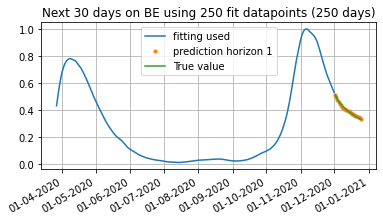

In [23]:
for loc in all_prediction:
    for i, pred in enumerate(all_prediction[loc]):
        prediction = pred
        fit = datapoints[loc][1][:max(fit_used[i])+1][:,0].reshape(-1)
        target_expected = np.array(all_targets[loc][i])
        
        fit_dates = fit_dates_used[i][:,0]
        prediction_dates = prediction_dates_used[i][:,0]
        
        fig = plt.figure(figsize=(6,3))
        plt.plot(fit_dates, fit, label="fitting used")
        plt.plot(prediction_dates, prediction[:,0], '.', label="prediction horizon 1")
        plt.plot(prediction_dates, target_expected[:,0], label="True value")
        
        ax = fig.axes[0]
        # set monthly locator
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        # set formatter
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        # set font and rotation for date tick labels
        plt.gcf().autofmt_xdate()
        
        plt.legend()
        plt.grid()
        days_used = fit_first_days + i*fit_steps_days
        plt.title(f"Next {fit_steps_days} days on {loc} using {len(fit_used[i])} fit datapoints ({days_used} days)")
        #plt.savefig(f"fit_{len(fit_used[i])}.png", dpi=300)

In [24]:
x_dates

[datetime.date(2020, 3, 26),
 datetime.date(2020, 3, 27),
 datetime.date(2020, 3, 28),
 datetime.date(2020, 3, 29),
 datetime.date(2020, 3, 30),
 datetime.date(2020, 3, 31),
 datetime.date(2020, 4, 1),
 datetime.date(2020, 4, 2),
 datetime.date(2020, 4, 3),
 datetime.date(2020, 4, 4),
 datetime.date(2020, 4, 5),
 datetime.date(2020, 4, 6),
 datetime.date(2020, 4, 7),
 datetime.date(2020, 4, 8),
 datetime.date(2020, 4, 9),
 datetime.date(2020, 4, 10),
 datetime.date(2020, 4, 11),
 datetime.date(2020, 4, 12),
 datetime.date(2020, 4, 13),
 datetime.date(2020, 4, 14),
 datetime.date(2020, 4, 15),
 datetime.date(2020, 4, 16),
 datetime.date(2020, 4, 17),
 datetime.date(2020, 4, 18),
 datetime.date(2020, 4, 19),
 datetime.date(2020, 4, 20),
 datetime.date(2020, 4, 21),
 datetime.date(2020, 4, 22),
 datetime.date(2020, 4, 23),
 datetime.date(2020, 4, 24),
 datetime.date(2020, 4, 25),
 datetime.date(2020, 4, 26),
 datetime.date(2020, 4, 27),
 datetime.date(2020, 4, 28),
 datetime.date(2020, 4,

# Comparison between several models

In [23]:
end_train = "2020-09-15"  # dates with respect to x, included
end_valid = "2020-11-25"
end_test = "2020-12-31"

date_f = "%Y-%m-%d"
max_dates = [datetime.strptime(end_train, date_f).date(),
            datetime.strptime(end_valid, date_f).date(),
            datetime.strptime(end_test, date_f).date()]
max_dates[-1] = min(max(x_dates), max_dates[-1])
max_train_idx, max_valid_idx, max_test_idx = np.where(np.isin(x_dates, max_dates))[0]

train_idx = list(reversed(range(max_train_idx, -1, -n_forecast)))
valid_idx = list(range(max_train_idx+1, max_valid_idx+1))
test_idx = list(range(max_valid_idx+1, max_test_idx+1))

def train_generator():
    return data_generator(train_idx)

def validation_generator():
    return data_generator(valid_idx)

def test_generator():
    return data_generator(valid_idx)

train_datapoints = {loc: data_value_region(train_idx, loc) for loc in geocodes}
valid_datapoints = {loc: data_value_region(valid_idx, loc) for loc in geocodes}
test_datapoints = {loc: data_value_region(test_idx, loc) for loc in geocodes}

## Toy model

In [24]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
LSTMModel = model
print(model.output_shape)

(None, 1)


In [25]:
#history = model.fit(x_train, y_train, epochs=400, verbose=1, shuffle=False)
LSTMModel.compile(loss="mse", optimizer='adam')
history = LSTMModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/2800
5/5 [==============================] - 1s 152ms/step - loss: 0.0717 - val_loss: 0.0786
Epoch 2/2800
5/5 [==============================] - 0s 20ms/step - loss: 0.0226 - val_loss: 0.0191
Epoch 3/2800
5/5 [==============================] - 0s 19ms/step - loss: 0.0158 - val_loss: 0.0103
Epoch 4/2800
5/5 [==============================] - 0s 19ms/step - loss: 0.0146 - val_loss: 0.0120
Epoch 5/2800
5/5 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0217
Epoch 6/2800
5/5 [==============================] - 0s 20ms/step - loss: 0.0080 - val_loss: 0.0220
Epoch 7/2800
5/5 [==============================] - 0s 20ms/step - loss: 0.0064 - val_loss: 0.0147
Epoch 8/2800
5/5 [==============================] - 0s 19ms/step - loss: 0.0056 - val_loss: 0.0112
Epoch 9/2800
5/5 [==============================] - 0s 19ms/step - loss: 0.0059 - val_loss: 0.0126
Epoch 10/2800
5/5 [==============================] - 0s 20ms/step - loss: 0.0055 - val_loss: 0.0155
Epoch 11

5/5 [==============================] - 0s 18ms/step - loss: 2.7833e-04 - val_loss: 0.0013
Epoch 82/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.7364e-04 - val_loss: 0.0012
Epoch 83/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.6909e-04 - val_loss: 0.0012
Epoch 84/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.6469e-04 - val_loss: 0.0012
Epoch 85/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.6043e-04 - val_loss: 0.0012
Epoch 86/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.5631e-04 - val_loss: 0.0012
Epoch 87/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.5232e-04 - val_loss: 0.0012
Epoch 88/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.4848e-04 - val_loss: 0.0012
Epoch 89/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.4476e-04 - val_loss: 0.0012
Epoch 90/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.41

5/5 [==============================] - 0s 19ms/step - loss: 1.5813e-04 - val_loss: 9.7898e-04
Epoch 159/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.5774e-04 - val_loss: 9.7784e-04
Epoch 160/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.5734e-04 - val_loss: 9.7671e-04
Epoch 161/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.5695e-04 - val_loss: 9.7557e-04
Epoch 162/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.5657e-04 - val_loss: 9.7444e-04
Epoch 163/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.5619e-04 - val_loss: 9.7331e-04
Epoch 164/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.5581e-04 - val_loss: 9.7219e-04
Epoch 165/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.5544e-04 - val_loss: 9.7107e-04
Epoch 166/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.5507e-04 - val_loss: 9.6995e-04
Epoch 167/2800
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 1.3439e-04 - val_loss: 8.9347e-04
Epoch 234/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.3412e-04 - val_loss: 8.9229e-04
Epoch 235/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.3385e-04 - val_loss: 8.9110e-04
Epoch 236/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.3357e-04 - val_loss: 8.8992e-04
Epoch 237/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.3330e-04 - val_loss: 8.8873e-04
Epoch 238/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.3303e-04 - val_loss: 8.8754e-04
Epoch 239/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.3276e-04 - val_loss: 8.8636e-04
Epoch 240/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.3249e-04 - val_loss: 8.8517e-04
Epoch 241/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.3222e-04 - val_loss: 8.8398e-04
Epoch 242/2800
5/5 [==============

5/5 [==============================] - 0s 19ms/step - loss: 1.1522e-04 - val_loss: 8.0222e-04
Epoch 309/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.1497e-04 - val_loss: 8.0098e-04
Epoch 310/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.1473e-04 - val_loss: 7.9973e-04
Epoch 311/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.1449e-04 - val_loss: 7.9848e-04
Epoch 312/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.1425e-04 - val_loss: 7.9723e-04
Epoch 313/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.1401e-04 - val_loss: 7.9598e-04
Epoch 314/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.1377e-04 - val_loss: 7.9473e-04
Epoch 315/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.1353e-04 - val_loss: 7.9348e-04
Epoch 316/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.1329e-04 - val_loss: 7.9223e-04
Epoch 317/2800
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 9.7680e-05 - val_loss: 7.0669e-04
Epoch 384/2800
5/5 [==============================] - 0s 19ms/step - loss: 9.7454e-05 - val_loss: 7.0539e-04
Epoch 385/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.7228e-05 - val_loss: 7.0409e-04
Epoch 386/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.7001e-05 - val_loss: 7.0278e-04
Epoch 387/2800
5/5 [==============================] - 0s 19ms/step - loss: 9.6775e-05 - val_loss: 7.0148e-04
Epoch 388/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.6550e-05 - val_loss: 7.0017e-04
Epoch 389/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.6324e-05 - val_loss: 6.9886e-04
Epoch 390/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.6098e-05 - val_loss: 6.9756e-04
Epoch 391/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.5873e-05 - val_loss: 6.9625e-04
Epoch 392/2800
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 8.1118e-05 - val_loss: 6.0660e-04
Epoch 459/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.0902e-05 - val_loss: 6.0523e-04
Epoch 460/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.0688e-05 - val_loss: 6.0386e-04
Epoch 461/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.0473e-05 - val_loss: 6.0249e-04
Epoch 462/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.0258e-05 - val_loss: 6.0112e-04
Epoch 463/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.0044e-05 - val_loss: 5.9975e-04
Epoch 464/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.9830e-05 - val_loss: 5.9837e-04
Epoch 465/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.9616e-05 - val_loss: 5.9700e-04
Epoch 466/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.9402e-05 - val_loss: 5.9563e-04
Epoch 467/2800
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 6.5537e-05 - val_loss: 5.0198e-04
Epoch 534/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.5339e-05 - val_loss: 5.0056e-04
Epoch 535/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.5141e-05 - val_loss: 4.9915e-04
Epoch 536/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.4944e-05 - val_loss: 4.9774e-04
Epoch 537/2800
5/5 [==============================] - 0s 19ms/step - loss: 6.4747e-05 - val_loss: 4.9632e-04
Epoch 538/2800
5/5 [==============================] - 0s 21ms/step - loss: 6.4550e-05 - val_loss: 4.9491e-04
Epoch 539/2800
5/5 [==============================] - 0s 20ms/step - loss: 6.4353e-05 - val_loss: 4.9349e-04
Epoch 540/2800
5/5 [==============================] - 0s 20ms/step - loss: 6.4157e-05 - val_loss: 4.9208e-04
Epoch 541/2800
5/5 [==============================] - 0s 21ms/step - loss: 6.3961e-05 - val_loss: 4.9066e-04
Epoch 542/2800
5/5 [==============

5/5 [==============================] - 0s 19ms/step - loss: 5.1884e-05 - val_loss: 3.9724e-04
Epoch 609/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.1724e-05 - val_loss: 3.9589e-04
Epoch 610/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.1564e-05 - val_loss: 3.9455e-04
Epoch 611/2800
5/5 [==============================] - 0s 19ms/step - loss: 5.1404e-05 - val_loss: 3.9320e-04
Epoch 612/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.1246e-05 - val_loss: 3.9186e-04
Epoch 613/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.1088e-05 - val_loss: 3.9053e-04
Epoch 614/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.0930e-05 - val_loss: 3.8919e-04
Epoch 615/2800
5/5 [==============================] - 0s 19ms/step - loss: 5.0773e-05 - val_loss: 3.8786e-04
Epoch 616/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.0618e-05 - val_loss: 3.8653e-04
Epoch 617/2800
5/5 [==============

5/5 [==============================] - 0s 19ms/step - loss: 4.1881e-05 - val_loss: 3.0565e-04
Epoch 684/2800
5/5 [==============================] - 0s 18ms/step - loss: 4.1775e-05 - val_loss: 3.0460e-04
Epoch 685/2800
5/5 [==============================] - 0s 18ms/step - loss: 4.1671e-05 - val_loss: 3.0355e-04
Epoch 686/2800
5/5 [==============================] - 0s 18ms/step - loss: 4.1566e-05 - val_loss: 3.0250e-04
Epoch 687/2800
5/5 [==============================] - 0s 19ms/step - loss: 4.1462e-05 - val_loss: 3.0146e-04
Epoch 688/2800
5/5 [==============================] - 0s 19ms/step - loss: 4.1359e-05 - val_loss: 3.0043e-04
Epoch 689/2800
5/5 [==============================] - 0s 18ms/step - loss: 4.1257e-05 - val_loss: 2.9940e-04
Epoch 690/2800
5/5 [==============================] - 0s 18ms/step - loss: 4.1156e-05 - val_loss: 2.9838e-04
Epoch 691/2800
5/5 [==============================] - 0s 18ms/step - loss: 4.1054e-05 - val_loss: 2.9736e-04
Epoch 692/2800
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 3.5401e-05 - val_loss: 2.4071e-04
Epoch 759/2800
5/5 [==============================] - 0s 18ms/step - loss: 3.5330e-05 - val_loss: 2.4002e-04
Epoch 760/2800
5/5 [==============================] - 0s 18ms/step - loss: 3.5259e-05 - val_loss: 2.3934e-04
Epoch 761/2800
5/5 [==============================] - 0s 18ms/step - loss: 3.5189e-05 - val_loss: 2.3867e-04
Epoch 762/2800
5/5 [==============================] - 0s 19ms/step - loss: 3.5120e-05 - val_loss: 2.3799e-04
Epoch 763/2800
5/5 [==============================] - 0s 18ms/step - loss: 3.5050e-05 - val_loss: 2.3733e-04
Epoch 764/2800
5/5 [==============================] - 0s 18ms/step - loss: 3.4981e-05 - val_loss: 2.3666e-04
Epoch 765/2800
5/5 [==============================] - 0s 18ms/step - loss: 3.4912e-05 - val_loss: 2.3600e-04
Epoch 766/2800
5/5 [==============================] - 0s 19ms/step - loss: 3.4843e-05 - val_loss: 2.3534e-04
Epoch 767/2800
5/5 [==============

5/5 [==============================] - 0s 21ms/step - loss: 3.0993e-05 - val_loss: 1.9900e-04
Epoch 834/2800
5/5 [==============================] - 0s 20ms/step - loss: 3.0946e-05 - val_loss: 1.9855e-04
Epoch 835/2800
5/5 [==============================] - 0s 20ms/step - loss: 3.0899e-05 - val_loss: 1.9810e-04
Epoch 836/2800
5/5 [==============================] - 0s 20ms/step - loss: 3.0852e-05 - val_loss: 1.9766e-04
Epoch 837/2800
5/5 [==============================] - 0s 20ms/step - loss: 3.0806e-05 - val_loss: 1.9722e-04
Epoch 838/2800
5/5 [==============================] - 0s 20ms/step - loss: 3.0761e-05 - val_loss: 1.9678e-04
Epoch 839/2800
5/5 [==============================] - 0s 18ms/step - loss: 3.0715e-05 - val_loss: 1.9634e-04
Epoch 840/2800
5/5 [==============================] - 0s 18ms/step - loss: 3.0670e-05 - val_loss: 1.9591e-04
Epoch 841/2800
5/5 [==============================] - 0s 18ms/step - loss: 3.0624e-05 - val_loss: 1.9547e-04
Epoch 842/2800
5/5 [==============

5/5 [==============================] - 0s 19ms/step - loss: 2.8150e-05 - val_loss: 1.7041e-04
Epoch 909/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.8120e-05 - val_loss: 1.7008e-04
Epoch 910/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.8090e-05 - val_loss: 1.6975e-04
Epoch 911/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.8060e-05 - val_loss: 1.6943e-04
Epoch 912/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.8030e-05 - val_loss: 1.6911e-04
Epoch 913/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.8001e-05 - val_loss: 1.6878e-04
Epoch 914/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.7972e-05 - val_loss: 1.6846e-04
Epoch 915/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.7943e-05 - val_loss: 1.6814e-04
Epoch 916/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.7914e-05 - val_loss: 1.6782e-04
Epoch 917/2800
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 2.6253e-05 - val_loss: 1.4835e-04
Epoch 984/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.6231e-05 - val_loss: 1.4809e-04
Epoch 985/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.6209e-05 - val_loss: 1.4782e-04
Epoch 986/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.6187e-05 - val_loss: 1.4756e-04
Epoch 987/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.6165e-05 - val_loss: 1.4729e-04
Epoch 988/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.6144e-05 - val_loss: 1.4703e-04
Epoch 989/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.6122e-05 - val_loss: 1.4676e-04
Epoch 990/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.6101e-05 - val_loss: 1.4650e-04
Epoch 991/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.6079e-05 - val_loss: 1.4624e-04
Epoch 992/2800
5/5 [==============

Epoch 1058/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.4695e-05 - val_loss: 1.2977e-04
Epoch 1059/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.4674e-05 - val_loss: 1.2954e-04
Epoch 1060/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.4653e-05 - val_loss: 1.2931e-04
Epoch 1061/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.4633e-05 - val_loss: 1.2908e-04
Epoch 1062/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.4612e-05 - val_loss: 1.2885e-04
Epoch 1063/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.4592e-05 - val_loss: 1.2862e-04
Epoch 1064/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.4571e-05 - val_loss: 1.2840e-04
Epoch 1065/2800
5/5 [==============================] - 0s 20ms/step - loss: 2.4551e-05 - val_loss: 1.2817e-04
Epoch 1066/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.4531e-05 - val_loss: 1.2794e-04
Epoch 1067

5/5 [==============================] - 0s 18ms/step - loss: 2.3170e-05 - val_loss: 1.1367e-04
Epoch 1133/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.3149e-05 - val_loss: 1.1346e-04
Epoch 1134/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.3128e-05 - val_loss: 1.1326e-04
Epoch 1135/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.3107e-05 - val_loss: 1.1305e-04
Epoch 1136/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.3086e-05 - val_loss: 1.1285e-04
Epoch 1137/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.3066e-05 - val_loss: 1.1264e-04
Epoch 1138/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.3045e-05 - val_loss: 1.1244e-04
Epoch 1139/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.3023e-05 - val_loss: 1.1223e-04
Epoch 1140/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.3002e-05 - val_loss: 1.1203e-04
Epoch 1141/2800
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 2.1602e-05 - val_loss: 9.9216e-05
Epoch 1207/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.1580e-05 - val_loss: 9.9030e-05
Epoch 1208/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.1558e-05 - val_loss: 9.8845e-05
Epoch 1209/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.1537e-05 - val_loss: 9.8659e-05
Epoch 1210/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.1516e-05 - val_loss: 9.8474e-05
Epoch 1211/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.1495e-05 - val_loss: 9.8289e-05
Epoch 1212/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.1473e-05 - val_loss: 9.8106e-05
Epoch 1213/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.1452e-05 - val_loss: 9.7921e-05
Epoch 1214/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.1430e-05 - val_loss: 9.7737e-05
Epoch 1215/2800
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 2.0008e-05 - val_loss: 8.6081e-05
Epoch 1281/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.9987e-05 - val_loss: 8.5911e-05
Epoch 1282/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.9965e-05 - val_loss: 8.5741e-05
Epoch 1283/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.9944e-05 - val_loss: 8.5572e-05
Epoch 1284/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.9922e-05 - val_loss: 8.5403e-05
Epoch 1285/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.9900e-05 - val_loss: 8.5234e-05
Epoch 1286/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.9878e-05 - val_loss: 8.5066e-05
Epoch 1287/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.9857e-05 - val_loss: 8.4897e-05
Epoch 1288/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.9835e-05 - val_loss: 8.4729e-05
Epoch 1289/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 1.8413e-05 - val_loss: 7.4049e-05
Epoch 1355/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.8392e-05 - val_loss: 7.3894e-05
Epoch 1356/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.8370e-05 - val_loss: 7.3739e-05
Epoch 1357/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.8349e-05 - val_loss: 7.3583e-05
Epoch 1358/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.8327e-05 - val_loss: 7.3428e-05
Epoch 1359/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.8306e-05 - val_loss: 7.3274e-05
Epoch 1360/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.8285e-05 - val_loss: 7.3119e-05
Epoch 1361/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.8264e-05 - val_loss: 7.2965e-05
Epoch 1362/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.8242e-05 - val_loss: 7.2810e-05
Epoch 1363/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 1.6849e-05 - val_loss: 6.3041e-05
Epoch 1429/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.6828e-05 - val_loss: 6.2899e-05
Epoch 1430/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.6808e-05 - val_loss: 6.2758e-05
Epoch 1431/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.6787e-05 - val_loss: 6.2616e-05
Epoch 1432/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.6766e-05 - val_loss: 6.2474e-05
Epoch 1433/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.6746e-05 - val_loss: 6.2334e-05
Epoch 1434/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.6726e-05 - val_loss: 6.2193e-05
Epoch 1435/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.6705e-05 - val_loss: 6.2052e-05
Epoch 1436/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.6684e-05 - val_loss: 6.1911e-05
Epoch 1437/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 1.5351e-05 - val_loss: 5.3065e-05
Epoch 1503/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.5332e-05 - val_loss: 5.2938e-05
Epoch 1504/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.5312e-05 - val_loss: 5.2811e-05
Epoch 1505/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.5292e-05 - val_loss: 5.2684e-05
Epoch 1506/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.5272e-05 - val_loss: 5.2557e-05
Epoch 1507/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.5253e-05 - val_loss: 5.2431e-05
Epoch 1508/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.5233e-05 - val_loss: 5.2305e-05
Epoch 1509/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.5213e-05 - val_loss: 5.2179e-05
Epoch 1510/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.5194e-05 - val_loss: 5.2052e-05
Epoch 1511/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 1.3950e-05 - val_loss: 4.4219e-05
Epoch 1577/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.3932e-05 - val_loss: 4.4107e-05
Epoch 1578/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.3914e-05 - val_loss: 4.3996e-05
Epoch 1579/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.3896e-05 - val_loss: 4.3886e-05
Epoch 1580/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.3878e-05 - val_loss: 4.3775e-05
Epoch 1581/2800
5/5 [==============================] - 0s 21ms/step - loss: 1.3860e-05 - val_loss: 4.3665e-05
Epoch 1582/2800
5/5 [==============================] - 0s 21ms/step - loss: 1.3842e-05 - val_loss: 4.3555e-05
Epoch 1583/2800
5/5 [==============================] - 0s 22ms/step - loss: 1.3824e-05 - val_loss: 4.3445e-05
Epoch 1584/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.3806e-05 - val_loss: 4.3336e-05
Epoch 1585/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 1.2684e-05 - val_loss: 3.6642e-05
Epoch 1651/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.2668e-05 - val_loss: 3.6549e-05
Epoch 1652/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.2652e-05 - val_loss: 3.6456e-05
Epoch 1653/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.2636e-05 - val_loss: 3.6364e-05
Epoch 1654/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.2620e-05 - val_loss: 3.6272e-05
Epoch 1655/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.2603e-05 - val_loss: 3.6180e-05
Epoch 1656/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.2587e-05 - val_loss: 3.6088e-05
Epoch 1657/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.2571e-05 - val_loss: 3.5996e-05
Epoch 1658/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.2555e-05 - val_loss: 3.5905e-05
Epoch 1659/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 1.1585e-05 - val_loss: 3.0420e-05
Epoch 1725/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.1572e-05 - val_loss: 3.0345e-05
Epoch 1726/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.1559e-05 - val_loss: 3.0271e-05
Epoch 1727/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.1546e-05 - val_loss: 3.0196e-05
Epoch 1728/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.1532e-05 - val_loss: 3.0122e-05
Epoch 1729/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.1519e-05 - val_loss: 3.0048e-05
Epoch 1730/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.1505e-05 - val_loss: 2.9974e-05
Epoch 1731/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.1492e-05 - val_loss: 2.9901e-05
Epoch 1732/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.1478e-05 - val_loss: 2.9828e-05
Epoch 1733/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 1.0662e-05 - val_loss: 2.5487e-05
Epoch 1799/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.0651e-05 - val_loss: 2.5428e-05
Epoch 1800/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.0640e-05 - val_loss: 2.5369e-05
Epoch 1801/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.0628e-05 - val_loss: 2.5311e-05
Epoch 1802/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.0617e-05 - val_loss: 2.5253e-05
Epoch 1803/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.0606e-05 - val_loss: 2.5195e-05
Epoch 1804/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.0594e-05 - val_loss: 2.5138e-05
Epoch 1805/2800
5/5 [==============================] - 0s 18ms/step - loss: 1.0583e-05 - val_loss: 2.5080e-05
Epoch 1806/2800
5/5 [==============================] - 0s 19ms/step - loss: 1.0571e-05 - val_loss: 2.5023e-05
Epoch 1807/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 9.8756e-06 - val_loss: 2.1632e-05
Epoch 1873/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.8660e-06 - val_loss: 2.1586e-05
Epoch 1874/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.8566e-06 - val_loss: 2.1540e-05
Epoch 1875/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.8469e-06 - val_loss: 2.1494e-05
Epoch 1876/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.8370e-06 - val_loss: 2.1449e-05
Epoch 1877/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.8271e-06 - val_loss: 2.1403e-05
Epoch 1878/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.8172e-06 - val_loss: 2.1358e-05
Epoch 1879/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.8072e-06 - val_loss: 2.1313e-05
Epoch 1880/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.7970e-06 - val_loss: 2.1268e-05
Epoch 1881/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 9.1839e-06 - val_loss: 1.8587e-05
Epoch 1947/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.1749e-06 - val_loss: 1.8550e-05
Epoch 1948/2800
5/5 [==============================] - 0s 19ms/step - loss: 9.1660e-06 - val_loss: 1.8514e-05
Epoch 1949/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.1573e-06 - val_loss: 1.8477e-05
Epoch 1950/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.1487e-06 - val_loss: 1.8441e-05
Epoch 1951/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.1400e-06 - val_loss: 1.8404e-05
Epoch 1952/2800
5/5 [==============================] - 0s 19ms/step - loss: 9.1312e-06 - val_loss: 1.8368e-05
Epoch 1953/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.1225e-06 - val_loss: 1.8332e-05
Epoch 1954/2800
5/5 [==============================] - 0s 18ms/step - loss: 9.1136e-06 - val_loss: 1.8296e-05
Epoch 1955/2800
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 8.5642e-06 - val_loss: 1.6132e-05
Epoch 2021/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.5565e-06 - val_loss: 1.6102e-05
Epoch 2022/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.5488e-06 - val_loss: 1.6072e-05
Epoch 2023/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.5409e-06 - val_loss: 1.6043e-05
Epoch 2024/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.5331e-06 - val_loss: 1.6013e-05
Epoch 2025/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.5255e-06 - val_loss: 1.5983e-05
Epoch 2026/2800
5/5 [==============================] - 0s 19ms/step - loss: 8.5179e-06 - val_loss: 1.5954e-05
Epoch 2027/2800
5/5 [==============================] - 0s 19ms/step - loss: 8.5098e-06 - val_loss: 1.5925e-05
Epoch 2028/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.5017e-06 - val_loss: 1.5895e-05
Epoch 2029/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 8.0145e-06 - val_loss: 1.4132e-05
Epoch 2095/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.0075e-06 - val_loss: 1.4107e-05
Epoch 2096/2800
5/5 [==============================] - 0s 18ms/step - loss: 8.0002e-06 - val_loss: 1.4083e-05
Epoch 2097/2800
5/5 [==============================] - 0s 19ms/step - loss: 7.9930e-06 - val_loss: 1.4059e-05
Epoch 2098/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.9861e-06 - val_loss: 1.4035e-05
Epoch 2099/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.9793e-06 - val_loss: 1.4011e-05
Epoch 2100/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.9724e-06 - val_loss: 1.3987e-05
Epoch 2101/2800
5/5 [==============================] - 0s 19ms/step - loss: 7.9656e-06 - val_loss: 1.3963e-05
Epoch 2102/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.9589e-06 - val_loss: 1.3939e-05
Epoch 2103/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 7.5383e-06 - val_loss: 1.2512e-05
Epoch 2169/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.5326e-06 - val_loss: 1.2492e-05
Epoch 2170/2800
5/5 [==============================] - 0s 19ms/step - loss: 7.5268e-06 - val_loss: 1.2473e-05
Epoch 2171/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.5210e-06 - val_loss: 1.2454e-05
Epoch 2172/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.5154e-06 - val_loss: 1.2434e-05
Epoch 2173/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.5098e-06 - val_loss: 1.2415e-05
Epoch 2174/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.5041e-06 - val_loss: 1.2396e-05
Epoch 2175/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.4982e-06 - val_loss: 1.2377e-05
Epoch 2176/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.4924e-06 - val_loss: 1.2358e-05
Epoch 2177/2800
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 7.1396e-06 - val_loss: 1.1220e-05
Epoch 2243/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.1345e-06 - val_loss: 1.1205e-05
Epoch 2244/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.1293e-06 - val_loss: 1.1190e-05
Epoch 2245/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.1243e-06 - val_loss: 1.1174e-05
Epoch 2246/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.1195e-06 - val_loss: 1.1159e-05
Epoch 2247/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.1148e-06 - val_loss: 1.1144e-05
Epoch 2248/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.1100e-06 - val_loss: 1.1128e-05
Epoch 2249/2800
5/5 [==============================] - 0s 18ms/step - loss: 7.1052e-06 - val_loss: 1.1113e-05
Epoch 2250/2800
5/5 [==============================] - 0s 19ms/step - loss: 7.1003e-06 - val_loss: 1.1098e-05
Epoch 2251/2800
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 6.8064e-06 - val_loss: 1.0201e-05
Epoch 2317/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.8021e-06 - val_loss: 1.0189e-05
Epoch 2318/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.7977e-06 - val_loss: 1.0177e-05
Epoch 2319/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.7929e-06 - val_loss: 1.0164e-05
Epoch 2320/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.7882e-06 - val_loss: 1.0152e-05
Epoch 2321/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.7837e-06 - val_loss: 1.0140e-05
Epoch 2322/2800
5/5 [==============================] - 0s 19ms/step - loss: 6.7793e-06 - val_loss: 1.0128e-05
Epoch 2323/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.7749e-06 - val_loss: 1.0116e-05
Epoch 2324/2800
5/5 [==============================] - 0s 19ms/step - loss: 6.7704e-06 - val_loss: 1.0105e-05
Epoch 2325/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 6.5097e-06 - val_loss: 9.3936e-06
Epoch 2391/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.5068e-06 - val_loss: 9.3838e-06
Epoch 2392/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.5043e-06 - val_loss: 9.3741e-06
Epoch 2393/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.5021e-06 - val_loss: 9.3643e-06
Epoch 2394/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.4997e-06 - val_loss: 9.3545e-06
Epoch 2395/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.4970e-06 - val_loss: 9.3448e-06
Epoch 2396/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.4944e-06 - val_loss: 9.3352e-06
Epoch 2397/2800
5/5 [==============================] - 0s 19ms/step - loss: 6.4918e-06 - val_loss: 9.3256e-06
Epoch 2398/2800
5/5 [==============================] - 0s 20ms/step - loss: 6.4890e-06 - val_loss: 9.3159e-06
Epoch 2399/2800
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 6.2729e-06 - val_loss: 8.7400e-06
Epoch 2465/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.2657e-06 - val_loss: 8.7321e-06
Epoch 2466/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.2570e-06 - val_loss: 8.7243e-06
Epoch 2467/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.2471e-06 - val_loss: 8.7166e-06
Epoch 2468/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.2363e-06 - val_loss: 8.7090e-06
Epoch 2469/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.2253e-06 - val_loss: 8.7014e-06
Epoch 2470/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.2140e-06 - val_loss: 8.6940e-06
Epoch 2471/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.2027e-06 - val_loss: 8.6866e-06
Epoch 2472/2800
5/5 [==============================] - 0s 18ms/step - loss: 6.1918e-06 - val_loss: 8.6792e-06
Epoch 2473/2800
5/5 [=====

5/5 [==============================] - 0s 19ms/step - loss: 5.6269e-06 - val_loss: 8.2151e-06
Epoch 2539/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.5837e-06 - val_loss: 8.2124e-06
Epoch 2540/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.5524e-06 - val_loss: 8.2095e-06
Epoch 2541/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.5341e-06 - val_loss: 8.2066e-06
Epoch 2542/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.5302e-06 - val_loss: 8.2035e-06
Epoch 2543/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.5421e-06 - val_loss: 8.2003e-06
Epoch 2544/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.5709e-06 - val_loss: 8.1968e-06
Epoch 2545/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.6172e-06 - val_loss: 8.1931e-06
Epoch 2546/2800
5/5 [==============================] - 0s 18ms/step - loss: 5.6809e-06 - val_loss: 8.1891e-06
Epoch 2547/2800
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 2.4310e-06 - val_loss: 8.4045e-06
Epoch 2613/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.4570e-06 - val_loss: 8.3768e-06
Epoch 2614/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.4868e-06 - val_loss: 8.3508e-06
Epoch 2615/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.5222e-06 - val_loss: 8.3257e-06
Epoch 2616/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.5660e-06 - val_loss: 8.3010e-06
Epoch 2617/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.6228e-06 - val_loss: 8.2766e-06
Epoch 2618/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.6992e-06 - val_loss: 8.2535e-06
Epoch 2619/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.8059e-06 - val_loss: 8.2345e-06
Epoch 2620/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.9606e-06 - val_loss: 8.2251e-06
Epoch 2621/2800
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 4.5155e-06 - val_loss: 7.6201e-06
Epoch 2687/2800
5/5 [==============================] - 0s 18ms/step - loss: 4.3155e-06 - val_loss: 7.6278e-06
Epoch 2688/2800
5/5 [==============================] - 0s 18ms/step - loss: 4.1492e-06 - val_loss: 7.6313e-06
Epoch 2689/2800
5/5 [==============================] - 0s 18ms/step - loss: 4.0175e-06 - val_loss: 7.6309e-06
Epoch 2690/2800
5/5 [==============================] - 0s 18ms/step - loss: 3.9198e-06 - val_loss: 7.6270e-06
Epoch 2691/2800
5/5 [==============================] - 0s 20ms/step - loss: 3.8556e-06 - val_loss: 7.6200e-06
Epoch 2692/2800
5/5 [==============================] - 0s 20ms/step - loss: 3.8241e-06 - val_loss: 7.6107e-06
Epoch 2693/2800
5/5 [==============================] - 0s 20ms/step - loss: 3.8257e-06 - val_loss: 7.5998e-06
Epoch 2694/2800
5/5 [==============================] - 0s 20ms/step - loss: 3.8607e-06 - val_loss: 7.5884e-06
Epoch 2695/2800
5/5 [=====

5/5 [==============================] - 0s 20ms/step - loss: 2.9457e-06 - val_loss: 9.4594e-06
Epoch 2761/2800
5/5 [==============================] - 0s 20ms/step - loss: 2.4491e-06 - val_loss: 9.3778e-06
Epoch 2762/2800
5/5 [==============================] - 0s 19ms/step - loss: 2.2516e-06 - val_loss: 9.2234e-06
Epoch 2763/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.1885e-06 - val_loss: 9.0503e-06
Epoch 2764/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.1846e-06 - val_loss: 8.9331e-06
Epoch 2765/2800
5/5 [==============================] - 0s 20ms/step - loss: 2.2117e-06 - val_loss: 8.8630e-06
Epoch 2766/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.2624e-06 - val_loss: 8.7845e-06
Epoch 2767/2800
5/5 [==============================] - 0s 20ms/step - loss: 2.3345e-06 - val_loss: 8.6873e-06
Epoch 2768/2800
5/5 [==============================] - 0s 18ms/step - loss: 2.4167e-06 - val_loss: 8.6076e-06
Epoch 2769/2800
5/5 [=====

TEST BE
MSE =  1.731792788329711e-06
MAE =  0.0010455791185040462


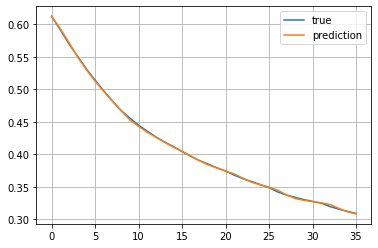

TEST FR-A
MSE =  1.978080103939046e-06
MAE =  0.0011630667917079782


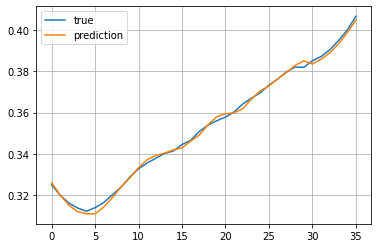

TEST FR-B
MSE =  1.0913648746861426e-05
MAE =  0.0026057525117345205


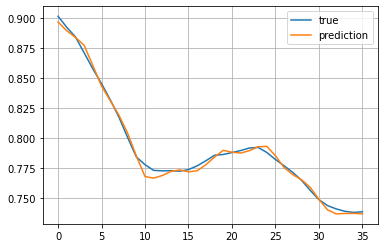

TEST FR-C
MSE =  1.1356188168348385e-05
MAE =  0.0026438212528215785


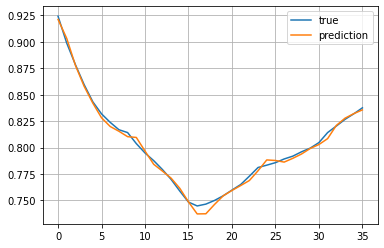

TEST FR-J
MSE =  3.186023424546376e-07
MAE =  0.0004485323784179944


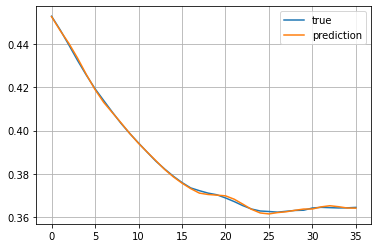

In [26]:
"""for loc in train_datapoints:
    print("TRAINING", loc)
    x, y = train_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in valid_datapoints:
    print("VALIDATION", loc)
    x, y = valid_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()"""

for loc in test_datapoints:
    MSE = 0
    MAE = 0
    print("TEST", loc)
    x, y = test_datapoints[loc]
    yp = model.predict(x)
    MSE = mean_squared_error(y.reshape(-1), yp.reshape(-1))
    MAE = mean_absolute_error(y.reshape(-1), yp.reshape(-1))
    print("MSE = ", MSE)
    print("MAE = ", MAE)
    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
# Let's use the validation set

## Base line models
### MultiStepLastBaseline
This model repeats the last value of hospitalisations `n_forecast` time

In [27]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def call(self, inputs):
        a = inputs[:, -1:, target_idx:target_idx+1]  # target of the last days
        return tf.tile(
            a,
            [1, n_forecast, 1]   # repeat target n_forecast time
        )

BaselineModel = MultiStepLastBaseline()
BaselineModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

## Linear regression
linear regression of the last `n_sample` days used to predict the next `n_forecast` days

In [28]:
class LinearRegressionHospi(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def predict(self, inputs):
        y = inputs[:, :, target_idx]  # target of the last days
        length = len(inputs)
        x = np.arange(n_samples).reshape(-1,1)  # dates of the target
        result = np.zeros((length, n_forecast))
        for i in range(length):
            regr = LinearRegression().fit(x,y[i])  # linear regression of (days, target)
            result[i] = regr.predict(np.arange(n_samples, n_samples+n_forecast).reshape(-1,1))
        return result
        

## 1 fully connected layer (Dense model)

In [29]:
DenseModel = Sequential()
DenseModel.add(Lambda(lambda x: x[:,:,target_idx]))  # select only the target of the previous days
DenseModel.add(Dense(n_forecast))   # predict the next target based on the previous ones
DenseModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [30]:
LinearModel_history = DenseModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/2800
5/5 [==============================] - 0s 21ms/step - loss: 0.0048 - mean_absolute_error: 0.0355 - val_loss: 0.0097 - val_mean_absolute_error: 0.0695
Epoch 2/2800
5/5 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0358 - val_loss: 0.0090 - val_mean_absolute_error: 0.0671
Epoch 3/2800
5/5 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0346 - val_loss: 0.0085 - val_mean_absolute_error: 0.0653
Epoch 4/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_absolute_error: 0.0334 - val_loss: 0.0080 - val_mean_absolute_error: 0.0636
Epoch 5/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_absolute_error: 0.0322 - val_loss: 0.0076 - val_mean_absolute_error: 0.0619
Epoch 6/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0311 - val_loss: 0.0072 - val_mean_absolute_error: 0.0602
Epoch 7/2800
5/5 [=========

5/5 [==============================] - 0s 10ms/step - loss: 1.3588e-04 - mean_absolute_error: 0.0063 - val_loss: 7.5107e-04 - val_mean_absolute_error: 0.0196
Epoch 51/2800
5/5 [==============================] - 0s 12ms/step - loss: 1.3403e-04 - mean_absolute_error: 0.0063 - val_loss: 7.3941e-04 - val_mean_absolute_error: 0.0194
Epoch 52/2800
5/5 [==============================] - 0s 13ms/step - loss: 1.3243e-04 - mean_absolute_error: 0.0063 - val_loss: 7.2875e-04 - val_mean_absolute_error: 0.0193
Epoch 53/2800
5/5 [==============================] - 0s 7ms/step - loss: 1.3104e-04 - mean_absolute_error: 0.0063 - val_loss: 7.1900e-04 - val_mean_absolute_error: 0.0191
Epoch 54/2800
5/5 [==============================] - 0s 7ms/step - loss: 1.2984e-04 - mean_absolute_error: 0.0063 - val_loss: 7.1006e-04 - val_mean_absolute_error: 0.0190
Epoch 55/2800
5/5 [==============================] - 0s 7ms/step - loss: 1.2881e-04 - mean_absolute_error: 0.0063 - val_loss: 7.0185e-04 - val_mean_absolute

Epoch 98/2800
5/5 [==============================] - 0s 7ms/step - loss: 1.1753e-04 - mean_absolute_error: 0.0061 - val_loss: 5.9410e-04 - val_mean_absolute_error: 0.0175
Epoch 99/2800
5/5 [==============================] - 0s 7ms/step - loss: 1.1739e-04 - mean_absolute_error: 0.0061 - val_loss: 5.9330e-04 - val_mean_absolute_error: 0.0174
Epoch 100/2800
5/5 [==============================] - 0s 6ms/step - loss: 1.1724e-04 - mean_absolute_error: 0.0061 - val_loss: 5.9252e-04 - val_mean_absolute_error: 0.0174
Epoch 101/2800
5/5 [==============================] - 0s 6ms/step - loss: 1.1709e-04 - mean_absolute_error: 0.0061 - val_loss: 5.9176e-04 - val_mean_absolute_error: 0.0174
Epoch 102/2800
5/5 [==============================] - 0s 7ms/step - loss: 1.1695e-04 - mean_absolute_error: 0.0061 - val_loss: 5.9101e-04 - val_mean_absolute_error: 0.0174
Epoch 103/2800
5/5 [==============================] - 0s 6ms/step - loss: 1.1680e-04 - mean_absolute_error: 0.0061 - val_loss: 5.9027e-04 - va

Epoch 146/2800
5/5 [==============================] - 0s 6ms/step - loss: 1.1076e-04 - mean_absolute_error: 0.0060 - val_loss: 5.6379e-04 - val_mean_absolute_error: 0.0170
Epoch 147/2800
5/5 [==============================] - 0s 7ms/step - loss: 1.1062e-04 - mean_absolute_error: 0.0060 - val_loss: 5.6323e-04 - val_mean_absolute_error: 0.0170
Epoch 148/2800
5/5 [==============================] - 0s 6ms/step - loss: 1.1049e-04 - mean_absolute_error: 0.0060 - val_loss: 5.6267e-04 - val_mean_absolute_error: 0.0170
Epoch 149/2800
5/5 [==============================] - 0s 6ms/step - loss: 1.1036e-04 - mean_absolute_error: 0.0060 - val_loss: 5.6211e-04 - val_mean_absolute_error: 0.0170
Epoch 150/2800
5/5 [==============================] - 0s 6ms/step - loss: 1.1022e-04 - mean_absolute_error: 0.0060 - val_loss: 5.6156e-04 - val_mean_absolute_error: 0.0170
Epoch 151/2800
5/5 [==============================] - 0s 6ms/step - loss: 1.1009e-04 - mean_absolute_error: 0.0060 - val_loss: 5.6100e-04 - 

5/5 [==============================] - 0s 6ms/step - loss: 1.0476e-04 - mean_absolute_error: 0.0058 - val_loss: 5.3869e-04 - val_mean_absolute_error: 0.0167
Epoch 194/2800
5/5 [==============================] - 0s 6ms/step - loss: 1.0464e-04 - mean_absolute_error: 0.0058 - val_loss: 5.3819e-04 - val_mean_absolute_error: 0.0167
Epoch 195/2800
5/5 [==============================] - 0s 6ms/step - loss: 1.0452e-04 - mean_absolute_error: 0.0058 - val_loss: 5.3768e-04 - val_mean_absolute_error: 0.0167
Epoch 196/2800
5/5 [==============================] - 0s 6ms/step - loss: 1.0440e-04 - mean_absolute_error: 0.0058 - val_loss: 5.3717e-04 - val_mean_absolute_error: 0.0167
Epoch 197/2800
5/5 [==============================] - 0s 7ms/step - loss: 1.0428e-04 - mean_absolute_error: 0.0058 - val_loss: 5.3666e-04 - val_mean_absolute_error: 0.0167
Epoch 198/2800
5/5 [==============================] - 0s 7ms/step - loss: 1.0416e-04 - mean_absolute_error: 0.0058 - val_loss: 5.3616e-04 - val_mean_absolu

Epoch 241/2800
5/5 [==============================] - 0s 6ms/step - loss: 9.9246e-05 - mean_absolute_error: 0.0057 - val_loss: 5.1529e-04 - val_mean_absolute_error: 0.0164
Epoch 242/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.9137e-05 - mean_absolute_error: 0.0057 - val_loss: 5.1482e-04 - val_mean_absolute_error: 0.0164
Epoch 243/2800
5/5 [==============================] - 0s 6ms/step - loss: 9.9029e-05 - mean_absolute_error: 0.0057 - val_loss: 5.1436e-04 - val_mean_absolute_error: 0.0164
Epoch 244/2800
5/5 [==============================] - 0s 6ms/step - loss: 9.8920e-05 - mean_absolute_error: 0.0057 - val_loss: 5.1389e-04 - val_mean_absolute_error: 0.0164
Epoch 245/2800
5/5 [==============================] - 0s 6ms/step - loss: 9.8812e-05 - mean_absolute_error: 0.0057 - val_loss: 5.1343e-04 - val_mean_absolute_error: 0.0164
Epoch 246/2800
5/5 [==============================] - 0s 6ms/step - loss: 9.8705e-05 - mean_absolute_error: 0.0057 - val_loss: 5.1297e-04 - 

5/5 [==============================] - 0s 7ms/step - loss: 9.4390e-05 - mean_absolute_error: 0.0055 - val_loss: 4.9431e-04 - val_mean_absolute_error: 0.0161
Epoch 289/2800
5/5 [==============================] - 0s 6ms/step - loss: 9.4292e-05 - mean_absolute_error: 0.0055 - val_loss: 4.9388e-04 - val_mean_absolute_error: 0.0161
Epoch 290/2800
5/5 [==============================] - 0s 6ms/step - loss: 9.4194e-05 - mean_absolute_error: 0.0055 - val_loss: 4.9346e-04 - val_mean_absolute_error: 0.0161
Epoch 291/2800
5/5 [==============================] - 0s 6ms/step - loss: 9.4097e-05 - mean_absolute_error: 0.0055 - val_loss: 4.9303e-04 - val_mean_absolute_error: 0.0161
Epoch 292/2800
5/5 [==============================] - 0s 6ms/step - loss: 9.3999e-05 - mean_absolute_error: 0.0055 - val_loss: 4.9261e-04 - val_mean_absolute_error: 0.0161
Epoch 293/2800
5/5 [==============================] - 0s 6ms/step - loss: 9.3902e-05 - mean_absolute_error: 0.0055 - val_loss: 4.9218e-04 - val_mean_absolu

Epoch 336/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.9930e-05 - mean_absolute_error: 0.0054 - val_loss: 4.7470e-04 - val_mean_absolute_error: 0.0158
Epoch 337/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.9842e-05 - mean_absolute_error: 0.0054 - val_loss: 4.7431e-04 - val_mean_absolute_error: 0.0158
Epoch 338/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.9754e-05 - mean_absolute_error: 0.0054 - val_loss: 4.7392e-04 - val_mean_absolute_error: 0.0158
Epoch 339/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.9667e-05 - mean_absolute_error: 0.0054 - val_loss: 4.7353e-04 - val_mean_absolute_error: 0.0158
Epoch 340/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.9579e-05 - mean_absolute_error: 0.0054 - val_loss: 4.7314e-04 - val_mean_absolute_error: 0.0158
Epoch 341/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.9492e-05 - mean_absolute_error: 0.0054 - val_loss: 4.7275e-04 - 

5/5 [==============================] - 0s 6ms/step - loss: 8.6002e-05 - mean_absolute_error: 0.0053 - val_loss: 4.5711e-04 - val_mean_absolute_error: 0.0156
Epoch 384/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.5923e-05 - mean_absolute_error: 0.0053 - val_loss: 4.5675e-04 - val_mean_absolute_error: 0.0156
Epoch 385/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.5844e-05 - mean_absolute_error: 0.0053 - val_loss: 4.5640e-04 - val_mean_absolute_error: 0.0156
Epoch 386/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.5765e-05 - mean_absolute_error: 0.0053 - val_loss: 4.5604e-04 - val_mean_absolute_error: 0.0156
Epoch 387/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.5686e-05 - mean_absolute_error: 0.0053 - val_loss: 4.5568e-04 - val_mean_absolute_error: 0.0156
Epoch 388/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.5608e-05 - mean_absolute_error: 0.0053 - val_loss: 4.5533e-04 - val_mean_absolu

Epoch 431/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.2392e-05 - mean_absolute_error: 0.0052 - val_loss: 4.4065e-04 - val_mean_absolute_error: 0.0154
Epoch 432/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.2321e-05 - mean_absolute_error: 0.0052 - val_loss: 4.4032e-04 - val_mean_absolute_error: 0.0154
Epoch 433/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.2250e-05 - mean_absolute_error: 0.0052 - val_loss: 4.4000e-04 - val_mean_absolute_error: 0.0154
Epoch 434/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.2179e-05 - mean_absolute_error: 0.0052 - val_loss: 4.3967e-04 - val_mean_absolute_error: 0.0154
Epoch 435/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.2109e-05 - mean_absolute_error: 0.0052 - val_loss: 4.3934e-04 - val_mean_absolute_error: 0.0154
Epoch 436/2800
5/5 [==============================] - 0s 6ms/step - loss: 8.2038e-05 - mean_absolute_error: 0.0052 - val_loss: 4.3902e-04 - 

5/5 [==============================] - 0s 6ms/step - loss: 7.9209e-05 - mean_absolute_error: 0.0051 - val_loss: 4.2587e-04 - val_mean_absolute_error: 0.0152
Epoch 479/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.9145e-05 - mean_absolute_error: 0.0051 - val_loss: 4.2557e-04 - val_mean_absolute_error: 0.0152
Epoch 480/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.9080e-05 - mean_absolute_error: 0.0051 - val_loss: 4.2527e-04 - val_mean_absolute_error: 0.0151
Epoch 481/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.9016e-05 - mean_absolute_error: 0.0051 - val_loss: 4.2497e-04 - val_mean_absolute_error: 0.0151
Epoch 482/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.8953e-05 - mean_absolute_error: 0.0051 - val_loss: 4.2467e-04 - val_mean_absolute_error: 0.0151
Epoch 483/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.8889e-05 - mean_absolute_error: 0.0051 - val_loss: 4.2437e-04 - val_mean_absolu

Epoch 526/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.6276e-05 - mean_absolute_error: 0.0051 - val_loss: 4.1200e-04 - val_mean_absolute_error: 0.0150
Epoch 527/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.6218e-05 - mean_absolute_error: 0.0051 - val_loss: 4.1173e-04 - val_mean_absolute_error: 0.0150
Epoch 528/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.6161e-05 - mean_absolute_error: 0.0051 - val_loss: 4.1145e-04 - val_mean_absolute_error: 0.0150
Epoch 529/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.6103e-05 - mean_absolute_error: 0.0051 - val_loss: 4.1118e-04 - val_mean_absolute_error: 0.0149
Epoch 530/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.6045e-05 - mean_absolute_error: 0.0051 - val_loss: 4.1090e-04 - val_mean_absolute_error: 0.0149
Epoch 531/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.5988e-05 - mean_absolute_error: 0.0051 - val_loss: 4.1063e-04 - 

5/5 [==============================] - 0s 6ms/step - loss: 7.3682e-05 - mean_absolute_error: 0.0050 - val_loss: 3.9952e-04 - val_mean_absolute_error: 0.0148
Epoch 574/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.3629e-05 - mean_absolute_error: 0.0050 - val_loss: 3.9927e-04 - val_mean_absolute_error: 0.0148
Epoch 575/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.3577e-05 - mean_absolute_error: 0.0050 - val_loss: 3.9901e-04 - val_mean_absolute_error: 0.0148
Epoch 576/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.3525e-05 - mean_absolute_error: 0.0050 - val_loss: 3.9876e-04 - val_mean_absolute_error: 0.0148
Epoch 577/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.3473e-05 - mean_absolute_error: 0.0050 - val_loss: 3.9851e-04 - val_mean_absolute_error: 0.0148
Epoch 578/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.3421e-05 - mean_absolute_error: 0.0050 - val_loss: 3.9825e-04 - val_mean_absolu

Epoch 621/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.1283e-05 - mean_absolute_error: 0.0050 - val_loss: 3.8778e-04 - val_mean_absolute_error: 0.0146
Epoch 622/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.1235e-05 - mean_absolute_error: 0.0050 - val_loss: 3.8755e-04 - val_mean_absolute_error: 0.0146
Epoch 623/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.1187e-05 - mean_absolute_error: 0.0049 - val_loss: 3.8731e-04 - val_mean_absolute_error: 0.0146
Epoch 624/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.1140e-05 - mean_absolute_error: 0.0049 - val_loss: 3.8708e-04 - val_mean_absolute_error: 0.0146
Epoch 625/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.1093e-05 - mean_absolute_error: 0.0049 - val_loss: 3.8684e-04 - val_mean_absolute_error: 0.0146
Epoch 626/2800
5/5 [==============================] - 0s 6ms/step - loss: 7.1046e-05 - mean_absolute_error: 0.0049 - val_loss: 3.8661e-04 - 

5/5 [==============================] - 0s 6ms/step - loss: 6.9149e-05 - mean_absolute_error: 0.0049 - val_loss: 3.7717e-04 - val_mean_absolute_error: 0.0144
Epoch 669/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.9106e-05 - mean_absolute_error: 0.0049 - val_loss: 3.7695e-04 - val_mean_absolute_error: 0.0144
Epoch 670/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.9063e-05 - mean_absolute_error: 0.0049 - val_loss: 3.7673e-04 - val_mean_absolute_error: 0.0144
Epoch 671/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.9020e-05 - mean_absolute_error: 0.0049 - val_loss: 3.7652e-04 - val_mean_absolute_error: 0.0144
Epoch 672/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.8976e-05 - mean_absolute_error: 0.0049 - val_loss: 3.7630e-04 - val_mean_absolute_error: 0.0144
Epoch 673/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.8934e-05 - mean_absolute_error: 0.0049 - val_loss: 3.7609e-04 - val_mean_absolu

Epoch 716/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.7164e-05 - mean_absolute_error: 0.0049 - val_loss: 3.6713e-04 - val_mean_absolute_error: 0.0143
Epoch 717/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.7125e-05 - mean_absolute_error: 0.0049 - val_loss: 3.6693e-04 - val_mean_absolute_error: 0.0143
Epoch 718/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.7085e-05 - mean_absolute_error: 0.0049 - val_loss: 3.6673e-04 - val_mean_absolute_error: 0.0143
Epoch 719/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.7046e-05 - mean_absolute_error: 0.0048 - val_loss: 3.6653e-04 - val_mean_absolute_error: 0.0143
Epoch 720/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.7007e-05 - mean_absolute_error: 0.0048 - val_loss: 3.6633e-04 - val_mean_absolute_error: 0.0143
Epoch 721/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.6968e-05 - mean_absolute_error: 0.0048 - val_loss: 3.6613e-04 - 

5/5 [==============================] - 0s 6ms/step - loss: 6.5387e-05 - mean_absolute_error: 0.0048 - val_loss: 3.5801e-04 - val_mean_absolute_error: 0.0141
Epoch 764/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.5351e-05 - mean_absolute_error: 0.0048 - val_loss: 3.5782e-04 - val_mean_absolute_error: 0.0141
Epoch 765/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.5315e-05 - mean_absolute_error: 0.0048 - val_loss: 3.5764e-04 - val_mean_absolute_error: 0.0141
Epoch 766/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.5278e-05 - mean_absolute_error: 0.0048 - val_loss: 3.5745e-04 - val_mean_absolute_error: 0.0141
Epoch 767/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.5243e-05 - mean_absolute_error: 0.0048 - val_loss: 3.5726e-04 - val_mean_absolute_error: 0.0141
Epoch 768/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.5207e-05 - mean_absolute_error: 0.0048 - val_loss: 3.5708e-04 - val_mean_absolu

Epoch 811/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.3720e-05 - mean_absolute_error: 0.0048 - val_loss: 3.4932e-04 - val_mean_absolute_error: 0.0140
Epoch 812/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.3687e-05 - mean_absolute_error: 0.0048 - val_loss: 3.4914e-04 - val_mean_absolute_error: 0.0140
Epoch 813/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.3654e-05 - mean_absolute_error: 0.0048 - val_loss: 3.4897e-04 - val_mean_absolute_error: 0.0140
Epoch 814/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.3620e-05 - mean_absolute_error: 0.0048 - val_loss: 3.4879e-04 - val_mean_absolute_error: 0.0140
Epoch 815/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.3587e-05 - mean_absolute_error: 0.0048 - val_loss: 3.4862e-04 - val_mean_absolute_error: 0.0140
Epoch 816/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.3554e-05 - mean_absolute_error: 0.0048 - val_loss: 3.4845e-04 - 

5/5 [==============================] - 0s 6ms/step - loss: 6.2215e-05 - mean_absolute_error: 0.0047 - val_loss: 3.4134e-04 - val_mean_absolute_error: 0.0139
Epoch 859/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.2184e-05 - mean_absolute_error: 0.0047 - val_loss: 3.4118e-04 - val_mean_absolute_error: 0.0138
Epoch 860/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.2153e-05 - mean_absolute_error: 0.0047 - val_loss: 3.4102e-04 - val_mean_absolute_error: 0.0138
Epoch 861/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.2122e-05 - mean_absolute_error: 0.0047 - val_loss: 3.4085e-04 - val_mean_absolute_error: 0.0138
Epoch 862/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.2092e-05 - mean_absolute_error: 0.0047 - val_loss: 3.4069e-04 - val_mean_absolute_error: 0.0138
Epoch 863/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.2061e-05 - mean_absolute_error: 0.0047 - val_loss: 3.4052e-04 - val_mean_absolu

Epoch 906/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.0790e-05 - mean_absolute_error: 0.0047 - val_loss: 3.3366e-04 - val_mean_absolute_error: 0.0137
Epoch 907/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.0761e-05 - mean_absolute_error: 0.0047 - val_loss: 3.3351e-04 - val_mean_absolute_error: 0.0137
Epoch 908/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.0732e-05 - mean_absolute_error: 0.0047 - val_loss: 3.3335e-04 - val_mean_absolute_error: 0.0137
Epoch 909/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.0704e-05 - mean_absolute_error: 0.0047 - val_loss: 3.3320e-04 - val_mean_absolute_error: 0.0137
Epoch 910/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.0675e-05 - mean_absolute_error: 0.0047 - val_loss: 3.3304e-04 - val_mean_absolute_error: 0.0137
Epoch 911/2800
5/5 [==============================] - 0s 6ms/step - loss: 6.0647e-05 - mean_absolute_error: 0.0047 - val_loss: 3.3289e-04 - 

5/5 [==============================] - 0s 6ms/step - loss: 5.9490e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2653e-04 - val_mean_absolute_error: 0.0136
Epoch 954/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.9463e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2638e-04 - val_mean_absolute_error: 0.0136
Epoch 955/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.9437e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2624e-04 - val_mean_absolute_error: 0.0136
Epoch 956/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.9410e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2609e-04 - val_mean_absolute_error: 0.0136
Epoch 957/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.9384e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2594e-04 - val_mean_absolute_error: 0.0136
Epoch 958/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.9357e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2579e-04 - val_mean_absolu

Epoch 1001/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.8248e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1957e-04 - val_mean_absolute_error: 0.0135
Epoch 1002/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.8223e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1943e-04 - val_mean_absolute_error: 0.0135
Epoch 1003/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.8198e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1929e-04 - val_mean_absolute_error: 0.0135
Epoch 1004/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.8173e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1914e-04 - val_mean_absolute_error: 0.0135
Epoch 1005/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.8148e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1900e-04 - val_mean_absolute_error: 0.0135
Epoch 1006/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.8123e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1886e

5/5 [==============================] - 0s 6ms/step - loss: 5.7105e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1301e-04 - val_mean_absolute_error: 0.0134
Epoch 1049/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.7081e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1287e-04 - val_mean_absolute_error: 0.0134
Epoch 1050/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.7058e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1273e-04 - val_mean_absolute_error: 0.0134
Epoch 1051/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.7034e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1259e-04 - val_mean_absolute_error: 0.0134
Epoch 1052/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.7011e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1246e-04 - val_mean_absolute_error: 0.0134
Epoch 1053/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.6987e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1232e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.6026e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0664e-04 - val_mean_absolute_error: 0.0133
Epoch 1096/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.6003e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0651e-04 - val_mean_absolute_error: 0.0133
Epoch 1097/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.5981e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0637e-04 - val_mean_absolute_error: 0.0132
Epoch 1098/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.5959e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0624e-04 - val_mean_absolute_error: 0.0132
Epoch 1099/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.5936e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0611e-04 - val_mean_absolute_error: 0.0132
Epoch 1100/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.5914e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0598e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.5003e-05 - mean_absolute_error: 0.0045 - val_loss: 3.0043e-04 - val_mean_absolute_error: 0.0131
Epoch 1143/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.4983e-05 - mean_absolute_error: 0.0045 - val_loss: 3.0031e-04 - val_mean_absolute_error: 0.0131
Epoch 1144/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.4960e-05 - mean_absolute_error: 0.0045 - val_loss: 3.0017e-04 - val_mean_absolute_error: 0.0131
Epoch 1145/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.4941e-05 - mean_absolute_error: 0.0045 - val_loss: 3.0005e-04 - val_mean_absolute_error: 0.0131
Epoch 1146/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.4917e-05 - mean_absolute_error: 0.0045 - val_loss: 2.9991e-04 - val_mean_absolute_error: 0.0131
Epoch 1147/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.4899e-05 - mean_absolute_error: 0.0045 - val_loss: 2.9979e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.4033e-05 - mean_absolute_error: 0.0045 - val_loss: 2.9437e-04 - val_mean_absolute_error: 0.0130
Epoch 1190/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.4012e-05 - mean_absolute_error: 0.0045 - val_loss: 2.9424e-04 - val_mean_absolute_error: 0.0130
Epoch 1191/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3993e-05 - mean_absolute_error: 0.0045 - val_loss: 2.9411e-04 - val_mean_absolute_error: 0.0130
Epoch 1192/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3973e-05 - mean_absolute_error: 0.0045 - val_loss: 2.9398e-04 - val_mean_absolute_error: 0.0130
Epoch 1193/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3953e-05 - mean_absolute_error: 0.0045 - val_loss: 2.9385e-04 - val_mean_absolute_error: 0.0130
Epoch 1194/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3933e-05 - mean_absolute_error: 0.0045 - val_loss: 2.9373e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.3110e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8842e-04 - val_mean_absolute_error: 0.0129
Epoch 1237/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3090e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8828e-04 - val_mean_absolute_error: 0.0129
Epoch 1238/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3073e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8817e-04 - val_mean_absolute_error: 0.0129
Epoch 1239/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3052e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8803e-04 - val_mean_absolute_error: 0.0129
Epoch 1240/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3034e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8791e-04 - val_mean_absolute_error: 0.0129
Epoch 1241/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3014e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8779e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.2230e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8258e-04 - val_mean_absolute_error: 0.0128
Epoch 1284/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2213e-05 - mean_absolute_error: 0.0044 - val_loss: 2.8246e-04 - val_mean_absolute_error: 0.0128
Epoch 1285/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2193e-05 - mean_absolute_error: 0.0044 - val_loss: 2.8233e-04 - val_mean_absolute_error: 0.0128
Epoch 1286/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2176e-05 - mean_absolute_error: 0.0044 - val_loss: 2.8222e-04 - val_mean_absolute_error: 0.0128
Epoch 1287/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2157e-05 - mean_absolute_error: 0.0044 - val_loss: 2.8209e-04 - val_mean_absolute_error: 0.0128
Epoch 1288/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2140e-05 - mean_absolute_error: 0.0044 - val_loss: 2.8197e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.1396e-05 - mean_absolute_error: 0.0044 - val_loss: 2.7691e-04 - val_mean_absolute_error: 0.0127
Epoch 1331/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1368e-05 - mean_absolute_error: 0.0044 - val_loss: 2.7674e-04 - val_mean_absolute_error: 0.0127
Epoch 1332/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1363e-05 - mean_absolute_error: 0.0044 - val_loss: 2.7668e-04 - val_mean_absolute_error: 0.0127
Epoch 1333/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1332e-05 - mean_absolute_error: 0.0044 - val_loss: 2.7649e-04 - val_mean_absolute_error: 0.0126
Epoch 1334/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1329e-05 - mean_absolute_error: 0.0044 - val_loss: 2.7645e-04 - val_mean_absolute_error: 0.0126
Epoch 1335/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1295e-05 - mean_absolute_error: 0.0044 - val_loss: 2.7624e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.8210e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5861e-04 - val_mean_absolute_error: 0.0122
Epoch 1378/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3753e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8697e-04 - val_mean_absolute_error: 0.0130
Epoch 1379/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.8014e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5769e-04 - val_mean_absolute_error: 0.0122
Epoch 1380/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3836e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8725e-04 - val_mean_absolute_error: 0.0130
Epoch 1381/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.7942e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5742e-04 - val_mean_absolute_error: 0.0121
Epoch 1382/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3758e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8685e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.3438e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8438e-04 - val_mean_absolute_error: 0.0129
Epoch 1425/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.7050e-05 - mean_absolute_error: 0.0042 - val_loss: 2.5175e-04 - val_mean_absolute_error: 0.0120
Epoch 1426/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3430e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8430e-04 - val_mean_absolute_error: 0.0129
Epoch 1427/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.7007e-05 - mean_absolute_error: 0.0042 - val_loss: 2.5147e-04 - val_mean_absolute_error: 0.0120
Epoch 1428/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3423e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8422e-04 - val_mean_absolute_error: 0.0129
Epoch 1429/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.6964e-05 - mean_absolute_error: 0.0042 - val_loss: 2.5120e-04 - val_mean_a

5/5 [==============================] - 0s 7ms/step - loss: 4.6120e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4580e-04 - val_mean_absolute_error: 0.0119
Epoch 1472/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3209e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8221e-04 - val_mean_absolute_error: 0.0129
Epoch 1473/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.6082e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4555e-04 - val_mean_absolute_error: 0.0119
Epoch 1474/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3197e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8211e-04 - val_mean_absolute_error: 0.0129
Epoch 1475/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.6044e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4531e-04 - val_mean_absolute_error: 0.0118
Epoch 1476/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.3186e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8201e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.2936e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7999e-04 - val_mean_absolute_error: 0.0128
Epoch 1519/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.5251e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4023e-04 - val_mean_absolute_error: 0.0117
Epoch 1520/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2924e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7990e-04 - val_mean_absolute_error: 0.0128
Epoch 1521/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.5216e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4001e-04 - val_mean_absolute_error: 0.0117
Epoch 1522/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2911e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7980e-04 - val_mean_absolute_error: 0.0128
Epoch 1523/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.5182e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3979e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.4489e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3536e-04 - val_mean_absolute_error: 0.0116
Epoch 1566/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2620e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7765e-04 - val_mean_absolute_error: 0.0128
Epoch 1567/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.4457e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3516e-04 - val_mean_absolute_error: 0.0116
Epoch 1568/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2606e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7754e-04 - val_mean_absolute_error: 0.0128
Epoch 1569/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.4426e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3496e-04 - val_mean_absolute_error: 0.0116
Epoch 1570/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2590e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7744e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.2296e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7539e-04 - val_mean_absolute_error: 0.0128
Epoch 1613/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.3752e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3069e-04 - val_mean_absolute_error: 0.0115
Epoch 1614/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2281e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7529e-04 - val_mean_absolute_error: 0.0128
Epoch 1615/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.3722e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3051e-04 - val_mean_absolute_error: 0.0115
Epoch 1616/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.2266e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7519e-04 - val_mean_absolute_error: 0.0128
Epoch 1617/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.3692e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3032e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.3089e-05 - mean_absolute_error: 0.0041 - val_loss: 2.2654e-04 - val_mean_absolute_error: 0.0114
Epoch 1660/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1944e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7306e-04 - val_mean_absolute_error: 0.0127
Epoch 1661/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.3062e-05 - mean_absolute_error: 0.0041 - val_loss: 2.2637e-04 - val_mean_absolute_error: 0.0114
Epoch 1662/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1929e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7297e-04 - val_mean_absolute_error: 0.0127
Epoch 1663/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.3033e-05 - mean_absolute_error: 0.0041 - val_loss: 2.2620e-04 - val_mean_absolute_error: 0.0114
Epoch 1664/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1915e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7287e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.1598e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7087e-04 - val_mean_absolute_error: 0.0127
Epoch 1707/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.2437e-05 - mean_absolute_error: 0.0041 - val_loss: 2.2251e-04 - val_mean_absolute_error: 0.0113
Epoch 1708/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1582e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7077e-04 - val_mean_absolute_error: 0.0127
Epoch 1709/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.2410e-05 - mean_absolute_error: 0.0041 - val_loss: 2.2234e-04 - val_mean_absolute_error: 0.0113
Epoch 1710/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1567e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7068e-04 - val_mean_absolute_error: 0.0127
Epoch 1711/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.2384e-05 - mean_absolute_error: 0.0041 - val_loss: 2.2218e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.1842e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1888e-04 - val_mean_absolute_error: 0.0112
Epoch 1754/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1230e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6861e-04 - val_mean_absolute_error: 0.0126
Epoch 1755/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.1816e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1872e-04 - val_mean_absolute_error: 0.0112
Epoch 1756/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1217e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6853e-04 - val_mean_absolute_error: 0.0126
Epoch 1757/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.1791e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1857e-04 - val_mean_absolute_error: 0.0112
Epoch 1758/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.1200e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6843e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.0874e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6649e-04 - val_mean_absolute_error: 0.0126
Epoch 1801/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.1248e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1530e-04 - val_mean_absolute_error: 0.0111
Epoch 1802/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.0860e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6641e-04 - val_mean_absolute_error: 0.0126
Epoch 1803/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.1224e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1516e-04 - val_mean_absolute_error: 0.0111
Epoch 1804/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.0845e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6631e-04 - val_mean_absolute_error: 0.0126
Epoch 1805/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.1200e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1501e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.0702e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1207e-04 - val_mean_absolute_error: 0.0110
Epoch 1848/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.0502e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6433e-04 - val_mean_absolute_error: 0.0125
Epoch 1849/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.0678e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1193e-04 - val_mean_absolute_error: 0.0110
Epoch 1850/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.0486e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6424e-04 - val_mean_absolute_error: 0.0125
Epoch 1851/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.0655e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1179e-04 - val_mean_absolute_error: 0.0110
Epoch 1852/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.0472e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6416e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 5.0144e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6230e-04 - val_mean_absolute_error: 0.0125
Epoch 1895/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.0152e-05 - mean_absolute_error: 0.0040 - val_loss: 2.0885e-04 - val_mean_absolute_error: 0.0109
Epoch 1896/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.0129e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6221e-04 - val_mean_absolute_error: 0.0125
Epoch 1897/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.0130e-05 - mean_absolute_error: 0.0040 - val_loss: 2.0873e-04 - val_mean_absolute_error: 0.0109
Epoch 1898/2800
5/5 [==============================] - 0s 6ms/step - loss: 5.0112e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6212e-04 - val_mean_absolute_error: 0.0125
Epoch 1899/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.0107e-05 - mean_absolute_error: 0.0040 - val_loss: 2.0859e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 3.9643e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0592e-04 - val_mean_absolute_error: 0.0108
Epoch 1942/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.9770e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6021e-04 - val_mean_absolute_error: 0.0125
Epoch 1943/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.9621e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0580e-04 - val_mean_absolute_error: 0.0108
Epoch 1944/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.9755e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6013e-04 - val_mean_absolute_error: 0.0125
Epoch 1945/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.9599e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0567e-04 - val_mean_absolute_error: 0.0108
Epoch 1946/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.9739e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6005e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.9414e-05 - mean_absolute_error: 0.0044 - val_loss: 2.5826e-04 - val_mean_absolute_error: 0.0124
Epoch 1989/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.9127e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0300e-04 - val_mean_absolute_error: 0.0107
Epoch 1990/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.9397e-05 - mean_absolute_error: 0.0044 - val_loss: 2.5817e-04 - val_mean_absolute_error: 0.0124
Epoch 1991/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.9106e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0288e-04 - val_mean_absolute_error: 0.0107
Epoch 1992/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.9382e-05 - mean_absolute_error: 0.0044 - val_loss: 2.5809e-04 - val_mean_absolute_error: 0.0124
Epoch 1993/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.9085e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0276e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 3.8647e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0031e-04 - val_mean_absolute_error: 0.0107
Epoch 2036/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.9041e-05 - mean_absolute_error: 0.0044 - val_loss: 2.5625e-04 - val_mean_absolute_error: 0.0124
Epoch 2037/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.8626e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0020e-04 - val_mean_absolute_error: 0.0107
Epoch 2038/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.9028e-05 - mean_absolute_error: 0.0044 - val_loss: 2.5618e-04 - val_mean_absolute_error: 0.0124
Epoch 2039/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.8606e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0008e-04 - val_mean_absolute_error: 0.0107
Epoch 2040/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.9011e-05 - mean_absolute_error: 0.0044 - val_loss: 2.5609e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.8690e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5438e-04 - val_mean_absolute_error: 0.0123
Epoch 2083/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.8159e-05 - mean_absolute_error: 0.0039 - val_loss: 1.9762e-04 - val_mean_absolute_error: 0.0106
Epoch 2084/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.8674e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5429e-04 - val_mean_absolute_error: 0.0123
Epoch 2085/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.8139e-05 - mean_absolute_error: 0.0039 - val_loss: 1.9751e-04 - val_mean_absolute_error: 0.0106
Epoch 2086/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.8659e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5421e-04 - val_mean_absolute_error: 0.0123
Epoch 2087/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.8119e-05 - mean_absolute_error: 0.0039 - val_loss: 1.9739e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 3.7703e-05 - mean_absolute_error: 0.0039 - val_loss: 1.9513e-04 - val_mean_absolute_error: 0.0105
Epoch 2130/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.8324e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5245e-04 - val_mean_absolute_error: 0.0123
Epoch 2131/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.7684e-05 - mean_absolute_error: 0.0039 - val_loss: 1.9502e-04 - val_mean_absolute_error: 0.0105
Epoch 2132/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.8310e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5237e-04 - val_mean_absolute_error: 0.0123
Epoch 2133/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.7664e-05 - mean_absolute_error: 0.0039 - val_loss: 1.9491e-04 - val_mean_absolute_error: 0.0105
Epoch 2134/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.8294e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5229e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.7977e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5064e-04 - val_mean_absolute_error: 0.0123
Epoch 2177/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.7239e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9262e-04 - val_mean_absolute_error: 0.0105
Epoch 2178/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.7962e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5056e-04 - val_mean_absolute_error: 0.0123
Epoch 2179/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.7219e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9251e-04 - val_mean_absolute_error: 0.0105
Epoch 2180/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.7947e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5048e-04 - val_mean_absolute_error: 0.0123
Epoch 2181/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.7200e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9241e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 3.6803e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9029e-04 - val_mean_absolute_error: 0.0104
Epoch 2224/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.7617e-05 - mean_absolute_error: 0.0043 - val_loss: 2.4877e-04 - val_mean_absolute_error: 0.0122
Epoch 2225/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.6784e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9019e-04 - val_mean_absolute_error: 0.0104
Epoch 2226/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.7603e-05 - mean_absolute_error: 0.0043 - val_loss: 2.4870e-04 - val_mean_absolute_error: 0.0122
Epoch 2227/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.6766e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9009e-04 - val_mean_absolute_error: 0.0104
Epoch 2228/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.7588e-05 - mean_absolute_error: 0.0043 - val_loss: 2.4862e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.7275e-05 - mean_absolute_error: 0.0043 - val_loss: 2.4701e-04 - val_mean_absolute_error: 0.0122
Epoch 2271/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.6358e-05 - mean_absolute_error: 0.0038 - val_loss: 1.8793e-04 - val_mean_absolute_error: 0.0103
Epoch 2272/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.7262e-05 - mean_absolute_error: 0.0043 - val_loss: 2.4694e-04 - val_mean_absolute_error: 0.0122
Epoch 2273/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.6340e-05 - mean_absolute_error: 0.0038 - val_loss: 1.8784e-04 - val_mean_absolute_error: 0.0103
Epoch 2274/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.7248e-05 - mean_absolute_error: 0.0043 - val_loss: 2.4687e-04 - val_mean_absolute_error: 0.0122
Epoch 2275/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.6322e-05 - mean_absolute_error: 0.0038 - val_loss: 1.8774e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 3.5941e-05 - mean_absolute_error: 0.0038 - val_loss: 1.8574e-04 - val_mean_absolute_error: 0.0103
Epoch 2318/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.6925e-05 - mean_absolute_error: 0.0043 - val_loss: 2.4522e-04 - val_mean_absolute_error: 0.0121
Epoch 2319/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.5923e-05 - mean_absolute_error: 0.0038 - val_loss: 1.8565e-04 - val_mean_absolute_error: 0.0103
Epoch 2320/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.6909e-05 - mean_absolute_error: 0.0043 - val_loss: 2.4514e-04 - val_mean_absolute_error: 0.0121
Epoch 2321/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.5905e-05 - mean_absolute_error: 0.0038 - val_loss: 1.8556e-04 - val_mean_absolute_error: 0.0103
Epoch 2322/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.6894e-05 - mean_absolute_error: 0.0043 - val_loss: 2.4507e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.6592e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4353e-04 - val_mean_absolute_error: 0.0121
Epoch 2365/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.5513e-05 - mean_absolute_error: 0.0038 - val_loss: 1.8352e-04 - val_mean_absolute_error: 0.0102
Epoch 2366/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.6574e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4344e-04 - val_mean_absolute_error: 0.0121
Epoch 2367/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.5495e-05 - mean_absolute_error: 0.0038 - val_loss: 1.8343e-04 - val_mean_absolute_error: 0.0102
Epoch 2368/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.6562e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4338e-04 - val_mean_absolute_error: 0.0121
Epoch 2369/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.5478e-05 - mean_absolute_error: 0.0038 - val_loss: 1.8334e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 3.5111e-05 - mean_absolute_error: 0.0037 - val_loss: 1.8144e-04 - val_mean_absolute_error: 0.0101
Epoch 2412/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.6245e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4177e-04 - val_mean_absolute_error: 0.0121
Epoch 2413/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.5094e-05 - mean_absolute_error: 0.0037 - val_loss: 1.8135e-04 - val_mean_absolute_error: 0.0101
Epoch 2414/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.6231e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4170e-04 - val_mean_absolute_error: 0.0120
Epoch 2415/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.5077e-05 - mean_absolute_error: 0.0037 - val_loss: 1.8126e-04 - val_mean_absolute_error: 0.0101
Epoch 2416/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.6218e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4164e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.5919e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4013e-04 - val_mean_absolute_error: 0.0120
Epoch 2459/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.4700e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7933e-04 - val_mean_absolute_error: 0.0101
Epoch 2460/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.5904e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4005e-04 - val_mean_absolute_error: 0.0120
Epoch 2461/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.4683e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7924e-04 - val_mean_absolute_error: 0.0101
Epoch 2462/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.5890e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3998e-04 - val_mean_absolute_error: 0.0120
Epoch 2463/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.4666e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7916e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 3.4313e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7735e-04 - val_mean_absolute_error: 0.0100
Epoch 2506/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.5582e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3843e-04 - val_mean_absolute_error: 0.0120
Epoch 2507/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.4296e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7727e-04 - val_mean_absolute_error: 0.0100
Epoch 2508/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.5569e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3837e-04 - val_mean_absolute_error: 0.0120
Epoch 2509/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.4279e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7718e-04 - val_mean_absolute_error: 0.0100
Epoch 2510/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.5554e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3830e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.5265e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3684e-04 - val_mean_absolute_error: 0.0119
Epoch 2553/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.3916e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7534e-04 - val_mean_absolute_error: 0.0100
Epoch 2554/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.5249e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3677e-04 - val_mean_absolute_error: 0.0119
Epoch 2555/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.3899e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7526e-04 - val_mean_absolute_error: 0.0100
Epoch 2556/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.5235e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3669e-04 - val_mean_absolute_error: 0.0119
Epoch 2557/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.3883e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7517e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 3.3542e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7345e-04 - val_mean_absolute_error: 0.0099
Epoch 2600/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.4935e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3519e-04 - val_mean_absolute_error: 0.0119
Epoch 2601/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.3526e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7337e-04 - val_mean_absolute_error: 0.0099
Epoch 2602/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.4920e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3512e-04 - val_mean_absolute_error: 0.0119
Epoch 2603/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.3509e-05 - mean_absolute_error: 0.0037 - val_loss: 1.7329e-04 - val_mean_absolute_error: 0.0099
Epoch 2604/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.4906e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3505e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.4622e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3362e-04 - val_mean_absolute_error: 0.0119
Epoch 2647/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.3158e-05 - mean_absolute_error: 0.0036 - val_loss: 1.7152e-04 - val_mean_absolute_error: 0.0098
Epoch 2648/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.4609e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3356e-04 - val_mean_absolute_error: 0.0119
Epoch 2649/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.3142e-05 - mean_absolute_error: 0.0036 - val_loss: 1.7143e-04 - val_mean_absolute_error: 0.0098
Epoch 2650/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.4598e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3350e-04 - val_mean_absolute_error: 0.0119
Epoch 2651/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.3126e-05 - mean_absolute_error: 0.0036 - val_loss: 1.7136e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 3.2796e-05 - mean_absolute_error: 0.0036 - val_loss: 1.6970e-04 - val_mean_absolute_error: 0.0098
Epoch 2694/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.4302e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3202e-04 - val_mean_absolute_error: 0.0118
Epoch 2695/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.2781e-05 - mean_absolute_error: 0.0036 - val_loss: 1.6963e-04 - val_mean_absolute_error: 0.0098
Epoch 2696/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.4287e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3195e-04 - val_mean_absolute_error: 0.0118
Epoch 2697/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.2765e-05 - mean_absolute_error: 0.0036 - val_loss: 1.6955e-04 - val_mean_absolute_error: 0.0098
Epoch 2698/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.4276e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3190e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 4.3998e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3051e-04 - val_mean_absolute_error: 0.0118
Epoch 2741/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.2425e-05 - mean_absolute_error: 0.0036 - val_loss: 1.6785e-04 - val_mean_absolute_error: 0.0097
Epoch 2742/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.3985e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3044e-04 - val_mean_absolute_error: 0.0118
Epoch 2743/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.2410e-05 - mean_absolute_error: 0.0036 - val_loss: 1.6777e-04 - val_mean_absolute_error: 0.0097
Epoch 2744/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.3972e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3038e-04 - val_mean_absolute_error: 0.0118
Epoch 2745/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.2394e-05 - mean_absolute_error: 0.0036 - val_loss: 1.6769e-04 - val_mean_a

5/5 [==============================] - 0s 6ms/step - loss: 3.2075e-05 - mean_absolute_error: 0.0036 - val_loss: 1.6610e-04 - val_mean_absolute_error: 0.0097
Epoch 2788/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.3685e-05 - mean_absolute_error: 0.0041 - val_loss: 2.2894e-04 - val_mean_absolute_error: 0.0117
Epoch 2789/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.2060e-05 - mean_absolute_error: 0.0036 - val_loss: 1.6603e-04 - val_mean_absolute_error: 0.0097
Epoch 2790/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.3673e-05 - mean_absolute_error: 0.0041 - val_loss: 2.2888e-04 - val_mean_absolute_error: 0.0117
Epoch 2791/2800
5/5 [==============================] - 0s 6ms/step - loss: 3.2045e-05 - mean_absolute_error: 0.0036 - val_loss: 1.6595e-04 - val_mean_absolute_error: 0.0097
Epoch 2792/2800
5/5 [==============================] - 0s 6ms/step - loss: 4.3660e-05 - mean_absolute_error: 0.0041 - val_loss: 2.2882e-04 - val_mean_a

# Comparisons of the models

In [31]:
#LSTMModel = scan_object.best_model(metric='val_mse', asc=True)  # retrieve the best model from the scan
all_models = {
    'RepeatLast': BaselineModel,
    'LSTM': LSTMModel,
    'Dense': DenseModel,
    'Linear regression': LinearRegressionHospi()
}

def error_set(models, points, plot=True):
    y_predicted = {k:[] for k in models.keys()}
    y_true = []
    length = 0
    for loc in points:
        print(loc)
        length += 1
        x, y = points[loc]
        y = y.reshape(-1)
        y_true.extend(y)
        for name, model in models.items():
            yp = model.predict(x)
            yp = yp.reshape(-1)
            if plot:
                plt.plot(y, label='true')
                plt.plot(yp, label='prediction')
                plt.legend()
                plt.grid()
                plt.title(name)
                plt.show()
            y_predicted[name].extend(yp)
    MSE = []
    MAE = []
    models_names = []
    for k in models.keys():
        models_names.append(k)
        MSE.append(mean_squared_error(y_true, y_predicted[k]))
        MAE.append(mean_absolute_error(y_true, y_predicted[k]))
    return pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])

## Training

In [32]:
error_set(all_models, train_datapoints, plot=False)

BE
FR-A
FR-B
FR-C
FR-J


,MSE,MAE
Model,,
LSTM,0.000002,0.001133
Dense,0.000054,0.005059
RepeatLast,0.000081,0.005402
Linear regression,0.000425,0.009678


## Validation

BE


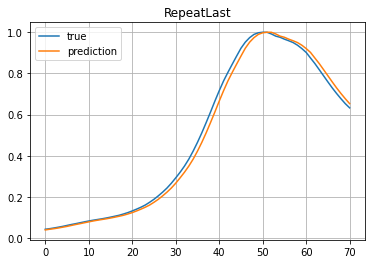

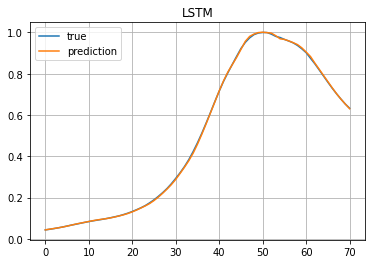

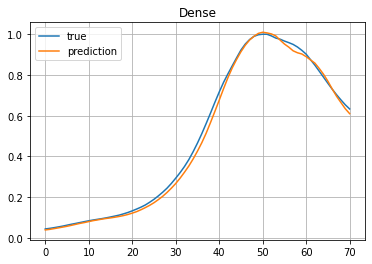

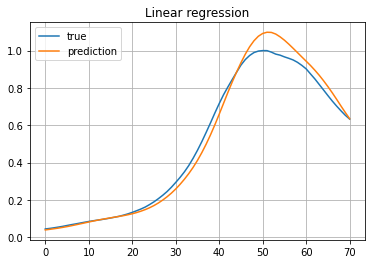

FR-A


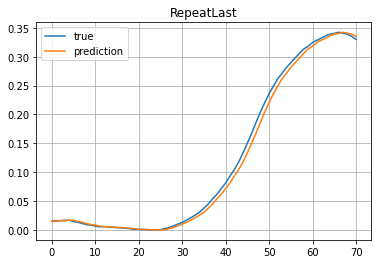

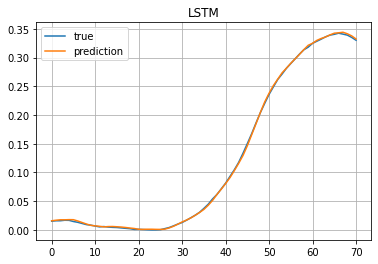

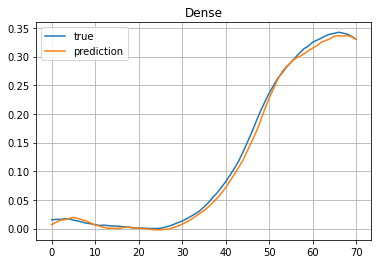

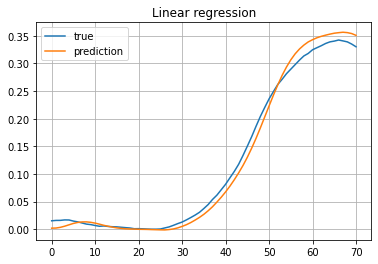

FR-B


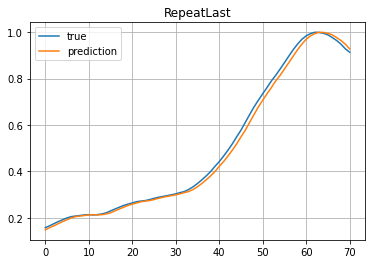

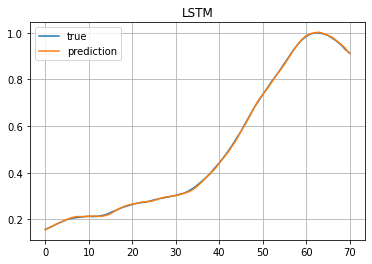

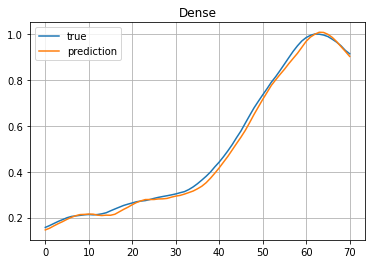

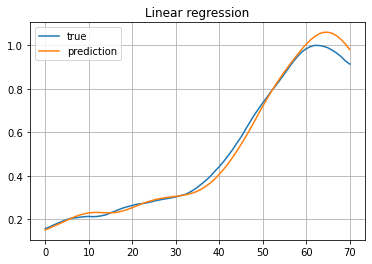

FR-C


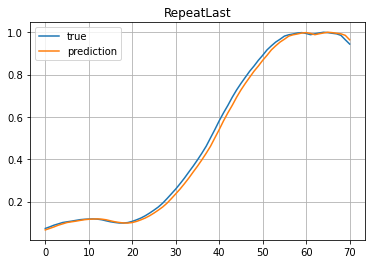

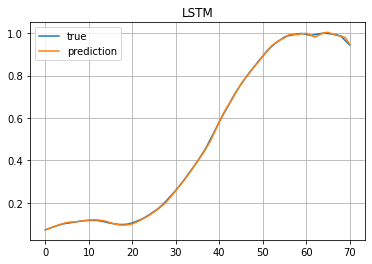

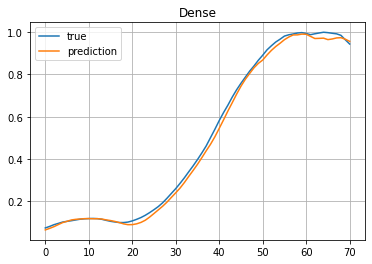

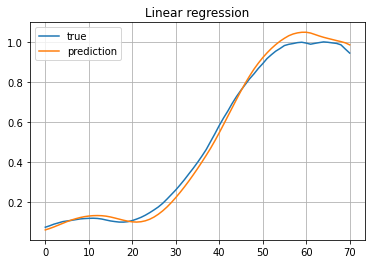

FR-J


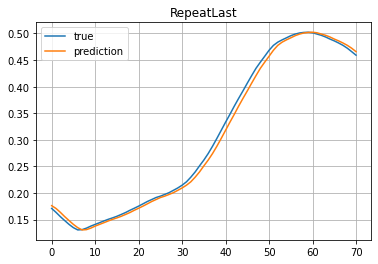

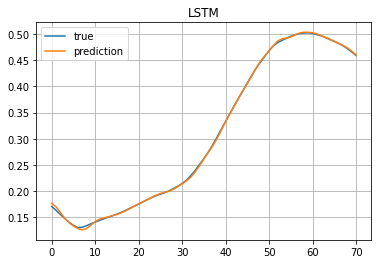

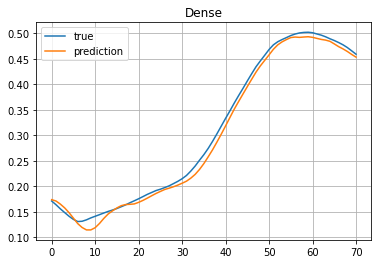

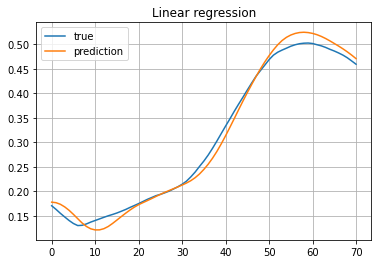

,MSE,MAE
Model,,
LSTM,0.000007,0.002018
Dense,0.000229,0.011731
RepeatLast,0.000268,0.011695
Linear regression,0.000815,0.020440


In [33]:
error_set(all_models, valid_datapoints)

## Test

BE


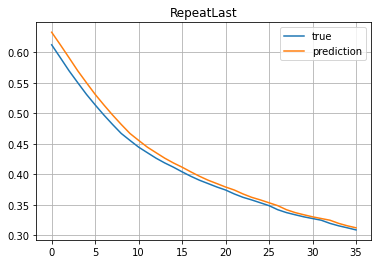

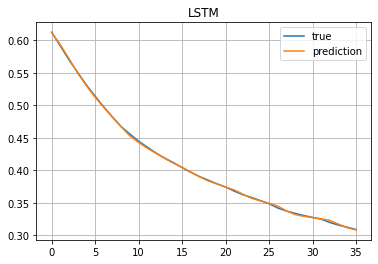

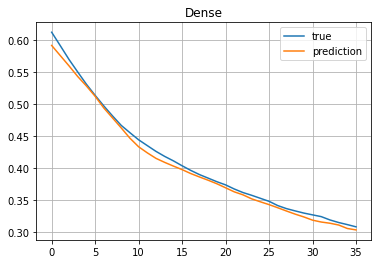

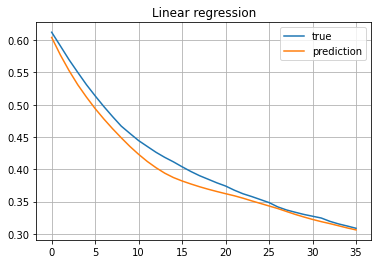

FR-A


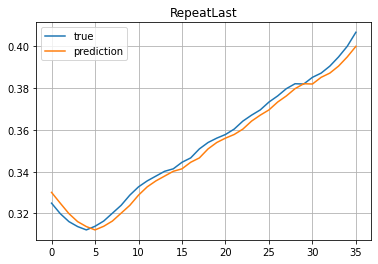

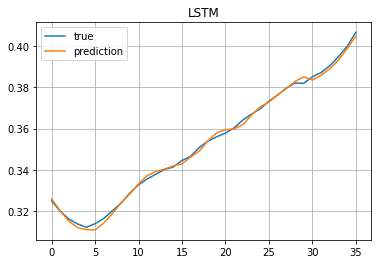

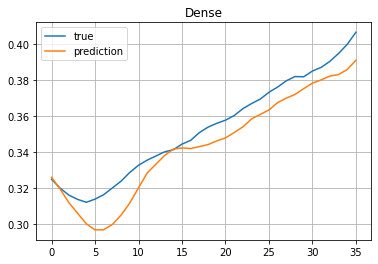

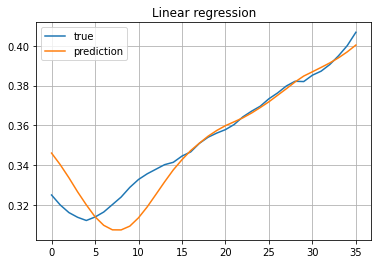

FR-B


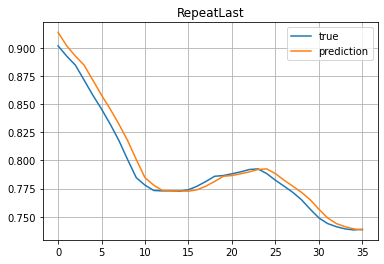

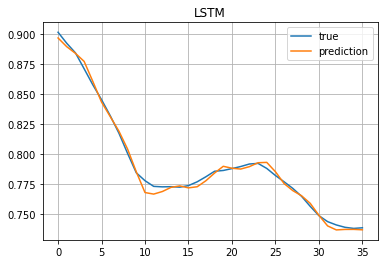

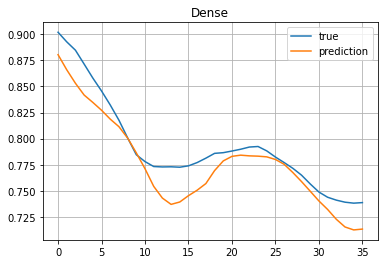

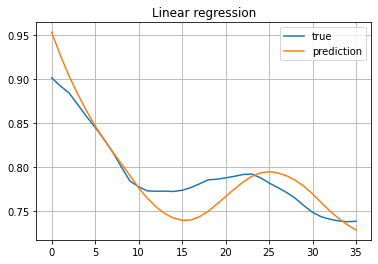

FR-C


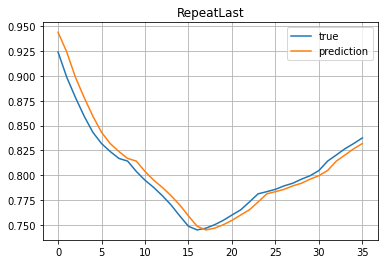

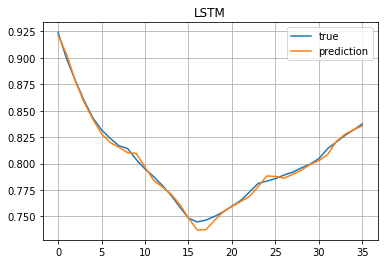

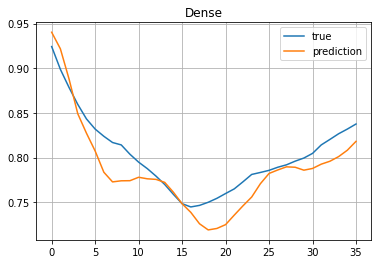

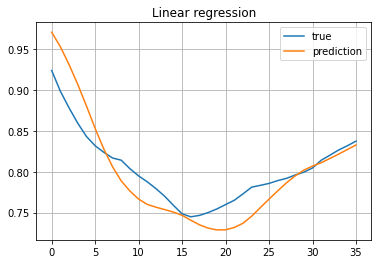

FR-J


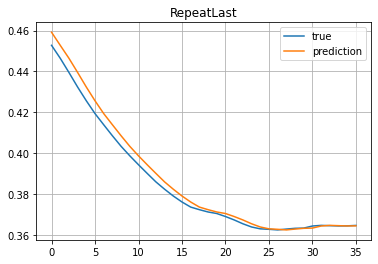

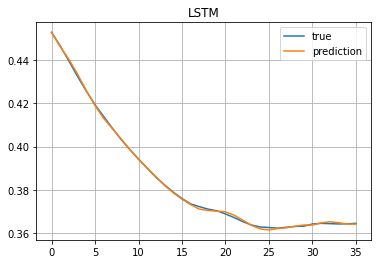

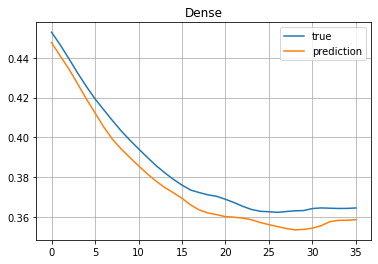

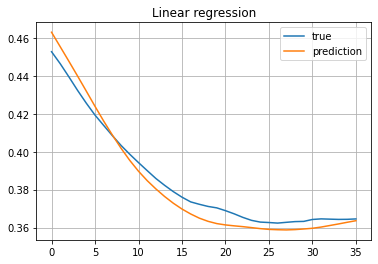

,MSE,MAE
Model,,
LSTM,0.000005,0.001581
RepeatLast,0.000060,0.005805
Dense,0.000216,0.011519
Linear regression,0.000286,0.012140


In [34]:
error_set(all_models, test_datapoints)